# Optimization for Statistical Learning Part 2 - Experiment Notebook #

## Section 0 Environment Setup ##

In this section, libraries, datasets and associative python programme are imported, as well as the setup of the experiment environment.

### Section 0.1 Packages and Libraries ###

**Packages Installation**

In [ ]:
!pip install jupyter
!pip install numpy
!pip install torch torchvision 
!pip install matplotlib
!pip install pandas
!pip install tensorflow
!pip install torch
!pip install torchvision
!pip install torch_xla
!pip install torch-neuron --extra-index-url=https://pip.repos.neuron.amazonaws.com/
!pip install pytorch torchvision cudatoolkit=9.0 -c pytorch

**Importing Libraries**

In [1]:
import math
import statistics
import random
import string
import timeit
from datetime import datetime
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt
import unicodedata
import os
import csv
#import cv2
from PIL import Image
import pandas as pd
import numpy as np
import copy
import torch
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset, Subset
from torch.optim.optimizer import (Optimizer, required, _use_grad_for_differentiable, _default_to_fused_or_foreach,
                        _differentiable_doc, _foreach_doc, _maximize_doc)
import torchvision.transforms as transforms

**Importing Python Programme**

Here is the section for importing external python files.

### Section 0.1 Set up Experiment Environment ###

**Utilize GPU**

For local environments, please utilize the GPU to speed up the training time.

In [2]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

**Utililze TPU**

To shorten the training time, we highly recommend that experiments should be done in Google Colab. Enable the following code in the Google Colab platform.

In [ ]:
## Assume that you are on the Google Colab platform.
#!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

import torch_xla
import torch_xla.core.xla_model as xm

device = xm.xla_device()

def to_device(data, device):
    data.to(device)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

### Section 0.2 Datasets ##

#### Section 0.2.0 Preprocessing Functions ####
Here are the functions for preprocessing the data.

In [ ]:
##############################
#       Normalization        #
##############################
def normalize_tensor(tensor):
    mean = torch.mean(tensor)
    std = torch.std(tensor)
    normalized_tensor = (tensor - mean) / std
    return normalized_tensor

##############################
#    Image Preprocessing     #
##############################
def load_image(filename):
  im_pil = Image.open(filename)
  im = np.array(im_pil).astype(np.float32) / 255
  return im

##############################
# Text Dataset Preprocessing #
##############################
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

#### Section 0.2.1 Importing Datasets from Packages ####
This will load the dataset automatically downloaded from the package. Remember the datasets will be stored in the folder "Datasets".

**MINST Dataset**

In [3]:
from torchvision.datasets import MNIST

# Download Dataset
MNIST_train_dataset = MNIST(root='./Datasets', train=True, download=True, transform=transforms.ToTensor())
MNIST_test_dataset = MNIST(root='./Datasets', train=False, download=True, transform=transforms.ToTensor())

# Load Dataset
train_dataset = MNIST_train_dataset
test_dataset = MNIST_test_dataset

# Show Dataset Status
current_dataset_name = "MNIST"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

54.2%

100.0%


Extracting ./Datasets\MNIST\raw\train-images-idx3-ubyte.gz to ./Datasets\MNIST\raw


100.0%
100.0%


Extracting ./Datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ./Datasets\MNIST\raw

Extracting ./Datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ./Datasets\MNIST\raw



100.0%


Extracting ./Datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./Datasets\MNIST\raw

The current dataset is MNIST.
Number of samples in the train dataset: 60000
Number of samples in the test dataset: 10000


In [ ]:
# Visualize the raw data from the dataset
print("=== Raw Data Samples from the MNIST Train Dataset ===")
for i in range(3):
    image, label = MNIST_train_dataset[i]
    image = image.squeeze().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()

print("=== Raw Data Samples from the MNIST Test Dataset ===")
for i in range(3):
    image, label = MNIST_test_dataset[i]
    image = image.squeeze().numpy()
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()

**CIFAR-10 Dataset**

In [ ]:
from torchvision.datasets import CIFAR10

# Download Dataset
CIFAR10_train_dataset = CIFAR10(root='./Datasets', train=True, download=True, transform=transforms.ToTensor())
CIFAR10_test_dataset = CIFAR10(root='./Datasets', train=False, download=True, transform=transforms.ToTensor())

# Load Dataset
train_dataset = CIFAR10_train_dataset
test_dataset = CIFAR10_test_dataset

# Show Dataset Status
current_dataset_name = "CIFAR10"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

In [ ]:
# Visualize the raw data from the CIFAR10 train dataset
print("=== Raw Data Samples from the CIFAR10 Train Dataset ===")
for i in range(3):
    image, label = CIFAR10_train_dataset[i]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.show()

# Visualize the raw data from the CIFAR10 test dataset
print("=== Raw Data Samples from the CIFAR10 Test Dataset ===")
for i in range(3):
    image, label = CIFAR10_test_dataset[i]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.show()

**EMNIST Dataset**

In [ ]:
from torchvision.datasets import EMNIST

# Download Dataset
EMNIST_train_dataset = EMNIST(root='./Datasets', split='byclass', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
EMNIST_test_dataset = EMNIST(root='./Datasets', split='byclass', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

# Load Dataset
train_dataset = EMNIST_train_dataset
test_dataset = EMNIST_test_dataset

# Show Dataset Status
current_dataset_name = "EMNIST"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

In [ ]:
# Visualize the raw data from the EMNIST train dataset
print("=== Raw Data Samples from the EMNIST Train Dataset ===")
for i in range(3):
    image, label = EMNIST_train_dataset[i]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.show()

# Visualize the raw data from the EMNIST test dataset
print("=== Raw Data Samples from the EMNIST Test Dataset ===")
for i in range(3):
    image, label = EMNIST_test_dataset[i]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.show()

#### Section 0.2.2 Importing Datasets from Downloaded Files ####
This will load the dataset downloaded in the local directories.

**Give Me Some Credit Dataset**

The source of this dataset comes from https://www.kaggle.com/c/GiveMeSomeCredit

Note: This dataset is borrowed from the datasets used in the competitive task in FTEC2101 Optimization Methods.

In [ ]:
# Define Dataset Structure
class Give_Me_Some_Credit_Dataset_Class(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.data, self.targets = self._load_data()

    def _load_data(self):
        data_frame = pd.read_csv(self.root)
        data = []
        targets = []

        for _, row in data_frame.iterrows():
            features = row.iloc[:-1].values.astype(np.float32)
            label = row.iloc[-1]
            data.append(features)
            targets.append(float(int(label)))
        
        data = torch.tensor(data)
        targets = torch.tensor(targets)
        return data, targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = self.data[index]
        label = self.targets[index]

        if self.transform is not None:
            features = self.transform(features)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return features, label

# Load Dataset
Give_Me_Some_Credit_train_dataset = Give_Me_Some_Credit_Dataset_Class(root='./Datasets/Give_Me_Some_Credit/ftec-cs-full-train.csv', train=True, transform=normalize_tensor)
Give_Me_Some_Credit_test_dataset = Give_Me_Some_Credit_Dataset_Class(root='./Datasets/Give_Me_Some_Credit/ftec-cs-full-test.csv', train=False, transform=normalize_tensor)

train_dataset = Give_Me_Some_Credit_train_dataset
test_dataset = Give_Me_Some_Credit_test_dataset

# Show Dataset Status
current_dataset_name = "Give Me Some Credit Dataset"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

**Epsilon Dataset**

Note: This dataset is best suited for binary classification. The training dataset contains 400000 objects. Each object is described by 2001 columns. The first column contains the label value, all other columns contain numerical features. The validation dataset contains 100000 objects. The structure is identical to the training dataset.

Warning: The loading time for this dataset is too long.

In [ ]:
# Define Dataset Structure
class EpsilonDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.data, self.targets = self._load_data()
    
    def process_line(self, line):
        line = line.split(' ')
        label, values = int(line[0]), line[1:]
        value = torch.zeros(line[1:].size())
        for item in values:
            idx, val = item.split(':')
            value[int(idx) - 1] = float(val)
        return label, value

    def _load_data(self):
        data_frame = pd.read_csv(self.root, nrows=20000)
        data = []
        targets = []

        with open(self.root, 'r') as fp:
            for line in fp:
                label, value = self.process_line(line.strip("\n"))
                data.append(value)
                targets.append(label)

        return data, targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = self.data[index]
        label = self.targets[index]

        if self.transform is not None:
            features = self.transform(features)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return features, label

# Load Dataset
Epsilon_train_dataset = EpsilonDataset(root='./Datasets/epsilon/epsilon_normalized', train=True, transform=None)
Epsilon_test_dataset = EpsilonDataset(root='./Datasets/epsilon/epsilon_normalized.t', train=False, transform=None)

train_dataset = Epsilon_train_dataset
test_dataset = Epsilon_test_dataset

# Show Dataset Status
current_dataset_name = "Epsilon"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

**Languages Dataset**

The dataset is downloaded from here: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [ ]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('Datasets/Language_dataset/names/*.txt'))

# Build the category_lines dictionary, a list of names per language
languages_dataset_category_lines = {}
languages_dataset_all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('Datasets/Language_dataset/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages_dataset_all_categories.append(category)
    lines = readLines(filename)
    languages_dataset_category_lines[category] = lines

n_categories = len(languages_dataset_all_categories)

class LanguageDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.data, self.targets = self._load_data()

    def _load_data(self):
        data_frame = pd.read_csv(self.root, nrows=20000)
        data = []
        targets = []

        with open(self.root, 'r') as fp:
            for line in fp:
                label, value = self.process_line(line.strip("\n"))
                data.append(value)
                targets.append(label)

        return data, targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = self.data[index]
        label = self.targets[index]

        if self.transform is not None:
            features = self.transform(features)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return features, label

Languages_train_dataset = LanguageDataset(root='./Datasets/epsilon/epsilon_normalized', train=True, transform=None)

## Section 1 Classes, Functions and Algorithms ##
All common and helping functions for machine learning tasks are defined here.

In [4]:
############################
#     Helping Functions    #
############################
# Random Seed Function
# To ensure a same training result under the random process, you might need to set the random seed via this function.
def set_random_seed(custom_random_seed):
    torch.manual_seed(custom_random_seed)
    random.seed(custom_random_seed)
    np.random.seed(custom_random_seed)

# Convert anything into a list if input is not a list
def convert_to_list(input_list):
    if not isinstance(input_list, list):
        input_list = [input_list]
    return input_list

# Graph Plotting Functions
def plot_cost_history(cost_history_list=[], save=True, x_label_name="Epochs", y_label_name="Cost", title_name="Culminative Send Cost History"):
    cost_history_list = convert_to_list(cost_history_list)
    for i, cost_history in enumerate(cost_history_list):
        plt.plot(cost_history, label=f"Cost History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if len(cost_history_list) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_culminative_send_cost_history_{train_start_time}.png')
    plt.show()

def plot_time_history(time_history_list=[], save=True, x_label_name="Epochs", y_label_name="Culminative Time Used", title_name="Time History"):
    time_history_list = convert_to_list(time_history_list)
    for i, time_history in enumerate(time_history_list):
        plt.plot(time_history, label=f"Time History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if len(time_history_list) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_time_history_{train_start_time}.png')
    plt.show()

def plot_adversary_history(adversary_history_list=[], save=True, x_label_name="Epochs", y_label_name="Adversaries", title_name="Number of Adversaries History"):
    adversary_history_list = convert_to_list(adversary_history_list)
    for i, adversary_history in enumerate(adversary_history_list):
        plt.plot(adversary_history, label=f"Adversary History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if len(adversary_history_list) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_adversary_history_{train_start_time}.png')
    plt.show()

def plot_straggler_history(straggler_history_list=[], save=True, x_label_name="Epochs", y_label_name="Stragglers", title_name="Number of Stragglers History"):
    straggler_history_list = convert_to_list(straggler_history_list)
    for i, straggler_history in enumerate(straggler_history_list):
        plt.plot(straggler_history, label=f"Straggler History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if len(straggler_history) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_straggler_history_{train_start_time}.png')
    plt.show()

def plot_loss_history(train_loss_history_list=[], test_loss_history_list=[], save=True, x_label_name="Epochs", y_label_name="Loss", title_name="Loss History"):
    train_loss_history_list = convert_to_list(train_loss_history_list)
    test_loss_history_list = convert_to_list(test_loss_history_list)
    for i, train_loss_history in enumerate(train_loss_history_list):
        plt.plot(train_loss_history, label=f"Train Loss History {i+1}")
    for i, test_loss_history in enumerate(test_loss_history_list):
        plt.plot(test_loss_history, label=f"Test Loss History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if (len(train_loss_history_list) + len(test_loss_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_loss_history_{train_start_time}.png')
    plt.show()

def plot_accuracy_history(train_accuracy_history_list=[], test_accuracy_history_list=[], save=True, x_label_name="Epochs", y_label_name="Accuracy", title_name="Accuracy History"):
    train_accuracy_history_list = convert_to_list(train_accuracy_history_list)
    test_accuracy_history_list = convert_to_list(test_accuracy_history_list)
    for i, train_accuracy_history in enumerate(train_accuracy_history_list):
        plt.plot(train_accuracy_history, label=f"Train Accuracy History {i+1}")
    for i, test_accuracy_history in enumerate(test_accuracy_history_list):
        plt.plot(test_accuracy_history, label=f"Test Accuracy History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if (len(train_accuracy_history_list) + len(test_accuracy_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_accuracy_history_{train_start_time}.png')
    plt.show()

def plot_error_history(train_error_history_list=[], test_error_history_list=[], save=True, x_label_name="Epochs", y_label_name="Error", title_name="Error History"):
    train_error_history_list = convert_to_list(train_error_history_list)
    test_error_history_list = convert_to_list(test_error_history_list)
    for i, train_error_history in enumerate(train_error_history_list):
        plt.plot(train_error_history, label=f"Train Error History {i+1}")
    for i, test_error_history in enumerate(test_error_history_list):
        plt.plot(test_error_history, label=f"Test Error History {i+1}")
    plt.xlabel(x_label_name)
    plt.ylabel(y_label_name)
    plt.title(title_name)
    if (len(train_error_history_list) + len(test_error_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_error_history_{train_start_time}.png')
    plt.show()

# Accuracy and Error Rate Calculation
def get_accuracy(outputs, labels):
    with torch.no_grad():
        if outputs.dim() > 1:
            _, predictions = torch.max(outputs, dim=1)
        else:
            predictions = outputs
        return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

def get_error(outputs, labels):
    with torch.no_grad():
        if outputs.dim() > 1:
            _, predictions = torch.max(outputs, dim=1)
        else:
            predictions = outputs
        return torch.tensor(torch.sum(predictions != labels).item() / len(predictions))

def relative_rate_to_client_number(num_client, percentage = 1.00):
    return round(num_client * percentage)

############################
#   Neural Network Model   #
############################
global Linear_Model_in_features
global Linear_Model_out_features
class Linear_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(in_features=Linear_Model_in_features, out_features=Linear_Model_out_features)
    
    def forward(self, x):
        x = self.linear(x)
        return torch.squeeze(x)

class MNIST_CNN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        if len(x.size()) == 1:  # Check if output has a single level of brackets
            x = x.unsqueeze(0)  # Add a dimension at the beginning
        return x

class CIFAR10_CNN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation_stack = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            torch.nn.BatchNorm2d(64),

            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            torch.nn.BatchNorm2d(128),

            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            torch.nn.BatchNorm2d(256),

            torch.nn.Flatten(), 
            torch.nn.Linear(256*4*4, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.activation_stack(x)
        if len(x.size()) == 1:  # Check if output has a single level of brackets
            x = x.unsqueeze(0)  # Add a dimension at the beginning
        return x

class EMNIST_CNN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.relu3 = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(128, 26)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        if len(x.size()) == 1:  # Check if output has a single level of brackets
            x = x.unsqueeze(0)  # Add a dimension at the beginning
        return x

class RNN_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation_stack = torch.nn.Sequential(
            torch.nn.RNN()
        )

############################
#    Iterate Algorithm     #
############################
def evaluate_model_simple(model, dataloader, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error):
    losses = []
    accuracies = []
    errors = []
    with torch.no_grad():
        for batch in dataloader:
            features, labels = batch
            outputs = model(features)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
    return loss_average, accuracy_average, error_average

def iterate_model_simple(model, dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True, test_dataloader=None, include_intial_history=False):
    loss_history = []
    accuracy_history = []
    error_history = []
    time_history = [0]
    start_time = timeit.default_timer()

    test_loss_history = []
    test_accuracy_history = []
    test_error_history = []

    if include_intial_history is True:
        loss, accuracy, error = evaluate_model_simple(model=model, dataloader=dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
        loss_history.append(loss)
        accuracy_history.append(accuracy)
        error_history.append(error)
        if test_dataloader is not None:
            test_loss, test_accuracy, test_error = evaluate_model_simple(model=model, dataloader=test_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
            test_loss_history.append(test_loss)
            test_accuracy_history.append(test_accuracy)
            test_error_history.append(test_error)

    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        errors = []
        for batch in dataloader:
            features, labels = batch
            outputs = model(features)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        time_used = timeit.default_timer() - start_time
        time_history.append(time_used)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
        loss_history.append(loss_average)
        accuracy_history.append(accuracy_average)
        error_history.append(error_average)
        if test_dataloader is not None:
            test_loss, test_accuracy, test_error = evaluate_model_simple(model=model, dataloader=test_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
            test_loss_history.append(test_loss)
            test_accuracy_history.append(test_accuracy)
            test_error_history.append(test_error)
        if show_history:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_average:.16f}, Train Accuracy: {accuracy_average:.16f}, Train Error: {error_average:.16f}, Culminative Time Used: {time_used}')
            if test_dataloader is not None:
                print(f'Test Loss: {test_loss:.16f}, Test Accuracy: {test_accuracy:.16f}, Test Error: {test_error:.16f}')
    if test_dataloader is not None:
        return loss_history, accuracy_history, error_history, time_history, test_loss_history, test_accuracy_history, test_error_history
    return loss_history, accuracy_history, error_history, time_history

##################################################################
#  Dataset Preprocessing Functions Before Splitting For Clients  #
##################################################################
# Acknowledge from https://github.com/adap/flower/blob/main/baselines/fedprox/fedprox/dataset_preparation.py
# Balance: Trims the dataset so each class contains as many elements as the class that contained the least elements.
def dataset_balance_classes(trainset, seed=42):
    class_counts = np.bincount(trainset.targets)
    smallest = np.min(class_counts)
    idxs = trainset.targets.argsort()
    tmp = [Subset(trainset, idxs[: int(smallest)])]
    tmp_targets = [trainset.targets[idxs[: int(smallest)]]]
    for count in np.cumsum(class_counts):
        tmp.append(Subset(trainset, idxs[int(count) : int(count + smallest)]))
        tmp_targets.append(trainset.targets[idxs[int(count) : int(count + smallest)]])
    unshuffled = ConcatDataset(tmp)
    unshuffled_targets = torch.cat(tmp_targets)
    shuffled_idxs = torch.randperm(
        len(unshuffled), generator=torch.Generator().manual_seed(seed)
    )
    shuffled = Subset(unshuffled, shuffled_idxs)
    shuffled.targets = unshuffled_targets[shuffled_idxs]
    return shuffled

def dataset_sort_by_class(trainset: Dataset):
    class_counts = np.bincount(trainset.targets)
    idxs = trainset.targets.argsort()  # sort targets in ascending order

    tmp = []  # create subset of smallest class
    tmp_targets = []  # same for targets

    start = 0
    for count in np.cumsum(class_counts):
        tmp.append(
            Subset(trainset, idxs[start : int(count + start)])
        )  # add rest of classes
        tmp_targets.append(trainset.targets[idxs[start : int(count + start)]])
        start += count
    sorted_dataset = ConcatDataset(tmp)  # concat dataset
    sorted_dataset.targets = torch.cat(tmp_targets)  # concat targets
    return sorted_dataset

# Implemention follow Li et al 2020: https://arxiv.org/abs/1812.06127 with default values set accordingly.
global custom_power_law_num_labels_per_partition
global custom_power_law_min_data_per_partition
global custom_power_law_mean
global custom_power_law_sigma
custom_power_law_num_labels_per_partition = 2
custom_power_law_min_data_per_partition = 10
custom_power_law_mean = 0.0
custom_power_law_sigma = 2.0
def dataset_power_law_split(sorted_trainset, num_partitions):
    # Custom Parameters
    num_labels_per_partition = custom_power_law_num_labels_per_partition
    min_data_per_partition = custom_power_law_min_data_per_partition
    mean = custom_power_law_mean
    sigma = custom_power_law_sigma

    targets = sorted_trainset.targets
    full_idx = list(range(len(targets)))

    class_counts = np.bincount(sorted_trainset.targets)
    labels_cs = np.cumsum(class_counts)
    labels_cs = [0] + labels_cs[:-1].tolist()

    partitions_idx: List[List[int]] = []
    num_classes = len(np.bincount(targets))
    hist = np.zeros(num_classes, dtype=np.int32)

    # assign min_data_per_partition
    min_data_per_class = int(min_data_per_partition / num_labels_per_partition)
    for u_id in range(num_partitions):
        partitions_idx.append([])
        for cls_idx in range(num_labels_per_partition):
            # label for the u_id-th client
            cls = (u_id + cls_idx) % num_classes
            # record minimum data
            indices = list(
                full_idx[
                    labels_cs[cls]
                    + hist[cls] : labels_cs[cls]
                    + hist[cls]
                    + min_data_per_class
                ]
            )
            partitions_idx[-1].extend(indices)
            hist[cls] += min_data_per_class

    # add remaining images following power-law
    probs = np.random.lognormal(
        mean,
        sigma,
        (num_classes, int(num_partitions / num_classes), num_labels_per_partition),
    )
    remaining_per_class = class_counts - hist
    # obtain how many samples each partition should be assigned for each of the
    # labels it contains
    # pylint: disable=too-many-function-args
    probs = (
        remaining_per_class.reshape(-1, 1, 1)
        * probs
        / np.sum(probs, (1, 2), keepdims=True)
    )

    for u_id in range(num_partitions):
        for cls_idx in range(num_labels_per_partition):
            cls = (u_id + cls_idx) % num_classes
            count = int(probs[cls, u_id // num_classes, cls_idx])

            # add count of specific class to partition
            indices = full_idx[
                labels_cs[cls] + hist[cls] : labels_cs[cls] + hist[cls] + count
            ]
            partitions_idx[u_id].extend(indices)
            hist[cls] += count

    # construct subsets
    partitions = [Subset(sorted_trainset, p) for p in partitions_idx]
    return partitions

# Distribute the training datasets to clients, remember it returns an array of datasets
def split_datasets_for_clients_random(dataset, num_clients=1):
    total_sample_size = len(dataset)
    samples_per_clients = total_sample_size // num_clients
    client_datasets = random_split(dataset, [min(i + samples_per_clients, total_sample_size) - i for i in range(0, total_sample_size, samples_per_clients)])
    return client_datasets

global custom_split_dataset_iid
global custom_split_dataset_power_law
global custom_split_dataset_balance
global custom_split_dataset_seed
custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42
def split_datasets_for_clients_custom(dataset, num_clients=1):
    # Custom Parameters
    iid=custom_split_dataset_iid
    power_law=custom_split_dataset_power_law
    balance=custom_split_dataset_balance
    seed=custom_split_dataset_seed

    trainset = dataset
    if balance:
        trainset = dataset_balance_classes(trainset, seed)

    partition_size = int(len(trainset) / num_clients)
    lengths = [partition_size] * num_clients

    if iid is True:
        client_datasets = random_split(trainset, lengths, torch.Generator().manual_seed(seed))
    else:
        if power_law is True:
            trainset_sorted = dataset_sort_by_class(trainset)
            client_datasets = dataset_power_law_split(
                trainset_sorted,
                num_partitions=num_clients,
            )
        else:
            shard_size = int(partition_size / 2)
            idxs = trainset.targets.argsort()
            sorted_data = Subset(trainset, idxs)
            tmp = []
            for idx in range(num_clients * 2):
                tmp.append(
                    Subset(
                        sorted_data, np.arange(shard_size * idx, shard_size * (idx + 1))
                    )
                )
            idxs_list = torch.randperm(
                num_clients * 2, generator=torch.Generator().manual_seed(seed)
            )
            client_datasets = [
                ConcatDataset((tmp[idxs_list[2 * i]], tmp[idxs_list[2 * i + 1]]))
                for i in range(num_clients)
            ]

    return client_datasets

############################
#      Client Devices      #
############################
# Define a custom class for each client so they can update separately
class ClientDevice:
    def __init__(self, client_id, model, optimizer, dataset, batch_size, iterate_func, loss_func, accuracy_func=get_accuracy, error_func=get_error):
        self.id = client_id
        self.model = model
        self.optimizer = optimizer
        self.dataset = dataset
        self.dataloader = DeviceDataLoader(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True), device)
        self.iterate_func = iterate_func
        self.loss_func = loss_func
        self.accuracy_func = accuracy_func
        self.error_func = error_func

        # Framework Specificed Variables
        self.straggler = False
        self.client_controls = {}
        self.full_batch_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False), device)

        # Custom Variables
        self.adversary = False
        self.adversary_attack_func = None
        self.adversary_attack_value = 0
        self.adversary_attack_Scaffold_all = False

    def load_weights(self, weights):
        self.model.load_state_dict(weights)

    def load_global_model(self, global_model):
        for parameters, new_parameters in zip(self.model.parameters(), global_model.parameters()):
            parameters.data = new_parameters.data.clone()

    def copy_local_weights(self):
        # This ensures dereferencing
        model_weights = {}
        for name, parameters in self.model.named_parameters():
            model_weights[name] = parameters.data.clone()
        return(model_weights)

    def copy_local_model(self):
        return self.model.state_dict().copy()

    def get_client_id(self):
        return self.id
    
    def get_dataset_size(self):
        return len(self.dataset)

    def save_local_history(self, num_epochs, loss_history, accuracy_history, error_history, time_history, value=train_start_time):
        filename = "{}_client_{}_with_local_epochs_{}_local_loss_accuracy_error_history_{}.npy".format(current_dataset_name, self.id, num_epochs, value)
        with open(filename, 'wb') as f:
            np.savez(f, loss_history=loss_history, accuracy_history=accuracy_history, error_history=error_history, time_history=time_history)

    def train(self, num_epochs, show_message=True, plot_history=False):
        if self.adversary is True:
            if show_message:
                print(f"!-- Client {self.id} is a adversary and start iterations. ---!")
            self.adversary_attack_func(self.model, self.adversary_attack_value, self.dataloader, num_epochs, self.optimizer, self.loss_func, self.accuracy_func, self.error_func)
        else:
            if self.straggler is True:
                if show_message:
                    print(f"!-- Client {self.id} is a straggler and start iterations. ---!")
                loss_history, accuracy_history, error_history, time_history = self.iterate_func(self.model, self.dataloader, random.randint(1, num_epochs), self.optimizer, self.loss_func, self.accuracy_func, self.error_func)
            else:
                if show_message:
                    print(f"!-- Client {self.id} is normal and start iterations. ---!")
                loss_history, accuracy_history, error_history, time_history = self.iterate_func(self.model, self.dataloader, num_epochs, self.optimizer, self.loss_func, self.accuracy_func, self.error_func)
        if plot_history:
            plot_time_history(time_history)
            plot_loss_history(loss_history)
            plot_accuracy_history(accuracy_history)
            plot_error_history(error_history)
        return self.copy_local_weights()

    ## == Framework Specificed Functions == ##
    def is_straggler(self):
        return self.straggler

    def get_local_client_controls(self):
        return self.client_controls

    def train_Scaffold(self, server_controls, num_epochs, Scaffold_update_controls_use_gradient, show_message=True, plot_history=False):
        if self.adversary is True:
            if show_message:
                print(f"!-- Client {self.id} is a adversary and start iterations. ---!")
            delta_weights, delta_client_controls = self.adversary_attack_func(self, self.adversary_attack_value, server_controls, self.dataloader, num_epochs, self.adversary_attack_Scaffold_all, self.loss_func, self.accuracy_func, self.error_func, Scaffold_update_controls_use_gradient)
        else:
            if self.straggler is True:
                if show_message:
                    print(f"!-- Client {self.id} is a straggler and start iterations. ---!")
                loss_history, accuracy_history, error_history, time_history, delta_weights, delta_client_controls = iterate_Scaffold_client(self, server_controls, self.dataloader, random.randint(1, num_epochs), self.optimizer, self.loss_func, self.accuracy_func, self.error_func, Scaffold_update_controls_use_gradient)
            else:
                if show_message:
                    print(f"!-- Client {self.id} is normal and start iterations. ---!")
                loss_history, accuracy_history, error_history, time_history, delta_weights, delta_client_controls = iterate_Scaffold_client(self, server_controls, self.dataloader, num_epochs, self.optimizer, self.loss_func, self.accuracy_func, self.error_func, Scaffold_update_controls_use_gradient)
        if plot_history:
            plot_time_history(time_history)
            plot_loss_history(loss_history)
            plot_accuracy_history(accuracy_history)
            plot_error_history(error_history)
        return delta_weights, delta_client_controls

# Establish client devices
def establish_client_devices(num_clients, model_list, optimizer_list, dataset_list, batch_size_list, iterate_func_list, loss_func_list, accuracy_func_list, error_func_list):
    client_device = [None] * num_clients
    for client_id in range(num_clients):
        client_device[client_id] = ClientDevice(client_id, model_list[client_id], optimizer_list[client_id], dataset_list[client_id], batch_size_list[client_id], iterate_func_list[client_id], loss_func_list[client_id], accuracy_func_list[client_id], error_func_list[client_id])
    return client_device

############################
#    Adversarial Attack    #
############################
def adversarial_attack_by_value(model, value, dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error):
    for parameters in model.parameters():
        parameters.data.fill_(value)
    loss, accuracy, error = evaluate_model_simple(model=model, dataloader=dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
    print(f'Loss: {loss:.16f}, Accuracy: {accuracy:.16f}, Test Error: {error:.16f}')

def adversarial_attack_by_random_range(model, value, dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error):
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.uniform_(-value, value)
            if m.bias is not None:
                m.bias.data.uniform_(-value, value)
        elif isinstance(m, torch.nn.Linear):
            m.weight.data.uniform_(-value, value)
            if m.bias is not None:
                m.bias.data.uniform_(-value, value)
    loss, accuracy, error = evaluate_model_simple(model=model, dataloader=dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
    print(f'Loss: {loss:.16f}, Accuracy: {accuracy:.16f}, Test Error: {error:.16f}')

def adversarial_attack_by_train_scaling(model, scale_value, dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error):
    loss_history = []
    accuracy_history = []
    error_history = []
    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        errors = []
        for batch in dataloader:
            features, labels = batch
            outputs = model(features)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
        loss_history.append(loss_average)
        accuracy_history.append(accuracy_average)
        error_history.append(error_average)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_average:.16f}, Accuracy: {accuracy_average:.16f}, Error: {error_average:.16f}')
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
            m.weight.data *= scale_value
            if m.bias is not None:
                m.bias.data *= scale_value
    loss, accuracy,error = evaluate_model_simple(model=model, dataloader=dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
    print(f'After scaling weight with {scale_value}, Loss: {loss:.16f}, Accuracy: {accuracy:.16f}, Test Error: {error:.16f}')

def adversarial_attack_by_value_Scaffold(client, value, server_controls, dataloader, num_epochs, all_bool, loss_func, accuracy_func, error_func, Scaffold_update_controls_use_gradient):
    local_model = client.model
    delta_weights = {}
    delta_client_controls = {}
    if all_bool is False:
        client_controls = client.client_controls
        client_controls_update = {}
        old_model = copy.deepcopy(local_model)
        temp = {}
        for name, parameters in local_model.named_parameters():
            parameters.data.fill_(value)
            temp[name] = parameters.data.clone()
        if Scaffold_update_controls_use_gradient is True:
            old_model.zero_grad()
            features, labels = next(iter(client.full_batch_dataloader))
            outputs = old_model(features)
            loss = loss_func(outputs, labels)
            loss.backward()
            for name, parameters in old_model.named_parameters():
                client_controls_update[name] = parameters.grad
                delta_weights[name] = temp[name] - parameters.data
                delta_client_controls[name] = client_controls_update[name] - client_controls[name]
        else:
            lr = client.optimizer.get_step_size()
            for name, parameters in old_model.named_parameters():
                client_controls_update[name] = client_controls[name] - server_controls[name] + (parameters.data - temp[name]) / (num_epochs * len(dataloader) * lr)
                delta_weights[name] = temp[name] - parameters.data
                delta_client_controls[name] = client_controls_update[name] - client_controls[name]
        client.client_controls = client_controls_update
    else:
        for name, parameters in local_model.named_parameters():
            parameters.data.fill_(value)
            delta_weights[name] = parameters.data.clone()
            delta_client_controls[name] = parameters.data.clone()
    loss, accuracy,error = evaluate_model_simple(model=local_model, dataloader=dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
    print(f'Loss: {loss:.16f}, Accuracy: {accuracy:.16f}, Test Error: {error:.16f}')
    return delta_weights, delta_client_controls

def adversarial_attack_by_control_variable_Scaffold(client, value, server_controls, dataloader, num_epochs, all_bool, loss_func, accuracy_func, error_func, Scaffold_update_controls_use_gradient):
    local_model = client.model
    optimizer = client.optimizer
    old_model = copy.deepcopy(local_model)
    client_controls = client.client_controls
    lr = optimizer.get_step_size()
    start_time = timeit.default_timer()
    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        errors = []
        for batch in dataloader:
            features, labels = batch
            outputs = local_model(features)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            loss.backward()
            optimizer.step(server_controls, client_controls)
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        time_used = timeit.default_timer() - start_time
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss_average:.16f}, Average Accuracy: {accuracy_average:.16f}, Average Error: {error_average:.16f}, Culminative Time Used: {time_used}')
    
    client_controls_update = {}
    delta_weights = {}
    delta_client_controls = {}
    temp = {}
    for name, parameters in local_model.named_parameters():
        temp[name] = parameters.data.clone()
    if Scaffold_update_controls_use_gradient is True:
        old_model.zero_grad()
        for batch in client.full_batch_dataloader:
            features, labels = batch
            outputs = old_model(features)
            loss = loss_func(outputs, labels)
            loss.backward()
        for name, parameters in old_model.named_parameters():
            client_controls_update[name] = parameters.grad
            delta_weights[name] = temp[name] - parameters.data
            delta_client_controls[name] = client_controls_update[name] - client_controls[name]
    else:
        for name, parameters in old_model.named_parameters():
            client_controls_update[name] = client_controls[name] - server_controls[name] + (parameters.data - temp[name]) / (num_epochs * len(dataloader) * lr)
            delta_weights[name] = temp[name] - parameters.data
            delta_client_controls[name] = client_controls_update[name] - client_controls[name]

    for name in delta_client_controls.keys():
        delta_client_controls[name] = torch.full_like(delta_client_controls[name], value)

    client.client_controls = client_controls_update

    return delta_weights, delta_client_controls

def adversarial_attack_by_random_range_Scaffold(client, value, server_controls, dataloader, num_epochs, all_bool, loss_func, accuracy_func, error_func, Scaffold_update_controls_use_gradient):
    local_model = client.model
    delta_weights = {}
    delta_client_controls = {}
    for m in local_model.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.uniform_(-value, value)
            if m.bias is not None:
                m.bias.data.uniform_(-value, value)
        elif isinstance(m, torch.nn.Linear):
            m.weight.data.uniform_(-value, value)
            if m.bias is not None:
                m.bias.data.uniform_(-value, value)
    loss, accuracy,error = evaluate_model_simple(model=local_model, dataloader=dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
    print(f'Loss: {loss:.16f}, Accuracy: {accuracy:.16f}, Test Error: {error:.16f}')
    if all_bool is False:
        client_controls = client.client_controls
        client_controls_update = {}
        old_model = copy.deepcopy(local_model)
        temp = {}
        for name, parameters in local_model.named_parameters():
            temp[name] = parameters.data.clone()
        if Scaffold_update_controls_use_gradient is True:
            old_model.zero_grad()
            for batch in client.full_batch_dataloader:
                features, labels = batch
                outputs = old_model(features)
                loss = loss_func(outputs, labels)
                loss.backward()
            for name, parameters in old_model.named_parameters():
                client_controls_update[name] = parameters.grad
                delta_weights[name] = temp[name] - parameters.data
                delta_client_controls[name] = client_controls_update[name] - client_controls[name]
        else:
            lr = client.optimizer.get_step_size()
            for name, parameters in old_model.named_parameters():
                client_controls_update[name] = client_controls[name] - server_controls[name] + (parameters.data - temp[name]) / (num_epochs * len(dataloader) * lr)
                delta_weights[name] = temp[name] - parameters.data
                delta_client_controls[name] = client_controls_update[name] - client_controls[name]
        client.client_controls = client_controls_update
    else:
        for name, parameters in local_model.named_parameters():
            delta_weights[name] = parameters.data.clone()
            delta_client_controls[name] = parameters.data.clone()
    loss, accuracy,error = evaluate_model_simple(model=local_model, dataloader=dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
    print(f'Loss: {loss:.16f}, Accuracy: {accuracy:.16f}, Test Error: {error:.16f}')
    return delta_weights, delta_client_controls

#########################################
#     Federated Learning Algorithms     #
#########################################
def federated_averaging(global_model, client_weights_total, num_clients, random_sample_client_number, global_step_size = 1.0):
    aggregated_weights = {}
    for name, parameters in global_model.named_parameters():
        aggregated_weights[name] = torch.zeros_like(parameters.data)

    for model in client_weights_total:
        for name, parameters in global_model.named_parameters():
            aggregated_weights[name] += model[name] / random_sample_client_number

    for name, parameters in global_model.named_parameters():
        parameters.data = global_step_size * aggregated_weights[name].data

def federated_median(global_model, client_weights_total, num_clients, random_sample_client_number, global_step_size = 1.0):
    aggregated_weights = {}
    for name, parameters in global_model.named_parameters():
        aggregated_weights[name] = []

    for model in client_weights_total:
        for name, parameters in global_model.named_parameters():
            aggregated_weights[name].append(model[name])

    for name, parameters in global_model.named_parameters():
        parameters.data = global_step_size * torch.from_numpy(np.median(aggregated_weights[name], axis=0))

def iterate_federated_learning_model(global_model, train_dataloader, test_dataloader, client_list, random_sample_client_number, global_epochs, local_epochs, aggregate_func=federated_averaging, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True):
    cost_history = [0]
    time_history = [0]
    adversary_history = [0]
    straggler_history = [0]
    
    send_cost = 0.00
    start_time = timeit.default_timer()

    train_loss_history = []
    train_accuracy_history = []
    train_error_history = []
    test_loss_history = []
    test_accuracy_history = []
    test_error_history = []

    # Initial Loss, Accuracy, Error
    train_loss, train_accuracy, train_error = evaluate_model_simple(model=global_model, dataloader=train_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    train_error_history.append(train_error)

    # Initialize server
    num_clients = len(client_list)

    if test_dataloader is not None:
        test_loss, test_accuracy, test_error = evaluate_model_simple(model=global_model, dataloader=test_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)
        test_error_history.append(test_error)

    for epoch in range(global_epochs):
        global_weights = global_model.state_dict()
        client_weights_total = []
        random_client_list = random.sample(client_list, random_sample_client_number)
        num_adversary_in_round = 0
        num_straggler_in_round = 0
        for client in random_client_list:
            send_cost += sum(value.numel() for value in global_weights.values())
            client.load_global_model(global_model)
            client_weights = client.train(num_epochs=local_epochs)
            client_weights_total.append(client_weights)
            send_cost += sum(value.numel() for value in client_weights.values())
            if client.adversary is True:
               num_adversary_in_round += 1
            else:
                if client.straggler is True:
                   num_straggler_in_round += 1
        aggregate_func(global_model, client_weights_total, num_clients, random_sample_client_number)

        # Record
        time_used = timeit.default_timer() - start_time
        cost_history.append(send_cost)
        time_history.append(time_used)
        adversary_history.append(num_adversary_in_round)
        straggler_history.append(num_straggler_in_round)

        train_loss, train_accuracy, train_error = evaluate_model_simple(model=global_model, dataloader=train_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        train_error_history.append(train_error)

        if test_dataloader is not None:
            test_loss, test_accuracy, test_error = evaluate_model_simple(model=global_model, dataloader=test_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
            test_loss_history.append(test_loss)
            test_accuracy_history.append(test_accuracy)
            test_error_history.append(test_error)

        if show_history:
            print("!-- Server Model Status --!")
            print(f'Epoch [{epoch+1}/{global_epochs}], Culminative Send Cost: {send_cost}, Culminative Time Used: {time_used}')
            print(f'Train Loss: {train_loss:.16f}, Train Accuracy: {train_accuracy:.16f}, Train Error: {train_error:.16f}')
            if test_dataloader is not None:
                print(f'Test Loss: {test_loss:.16f}, Test Accuracy: {test_accuracy:.16f}, Test Error: {test_error:.16f}')
            print(f'Number of adversaries sampled: {num_adversary_in_round}, Number of stragglers sampled: {num_straggler_in_round}')

    return cost_history, time_history, adversary_history, straggler_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

#################################
#  FedProx Framework Algorithm  #
#################################
def iterate_model_FedProx(model, dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True):
    loss_history = []
    accuracy_history = []
    error_history = []
    time_history = [0]
    start_time = timeit.default_timer()
    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        errors = []
        for batch in dataloader:
            features, labels = batch
            outputs = model(features)
            proximal_term = 0.0
            for w, w_t in zip(model.parameters(), FedProx_global_model.parameters()):
                proximal_term += torch.square((w - w_t).norm(2))
            loss = loss_func(outputs, labels) + (FedProx_mu / 2) * proximal_term
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        time_used = timeit.default_timer() - start_time
        time_history.append(time_used)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
        loss_history.append(loss_average)
        accuracy_history.append(accuracy_average)
        error_history.append(error_average)
        if show_history:
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss_average:.16f}, Average Accuracy: {accuracy_average:.16f}, Average Error: {error_average:.16f}, Culminative Time Used: {time_used}')
    return loss_history, accuracy_history, error_history, time_history

##################################
#  SCAFFOLD Framework Algorithm  #
##################################
# Inspired by https://github.com/ki-ljl/Scaffold-Federated-Learning/blob/main/ScaffoldOptimizer.py
# c: server_controls, ci: client_controls
class ScaffoldOptimizer(Optimizer):
    def __init__(self, params, lr=required, weight_decay=None):
        if lr is not required and lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if weight_decay is not None and weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(ScaffoldOptimizer, self).__init__(params, defaults)
                
    def step(self, server_controls, client_controls):
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            lr = group['lr']
            for parameters, c, ci in zip(group['params'], server_controls.values(), client_controls.values()):
                if parameters.grad is None:
                    continue
                parameters_derivative = parameters.grad.data - ci.data + c.data
                if weight_decay is not None:
                    parameters.data = weight_decay * parameters.data - lr * parameters_derivative.data
                else:
                    parameters.data = parameters.data - lr * parameters_derivative.data

    def get_step_size(self):
        return self.param_groups[0]['lr']

def iterate_Scaffold_client(client, server_controls, dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, Scaffold_update_controls_use_gradient=True, show_history=True):
    local_model = client.model
    old_model = copy.deepcopy(local_model)
    client_controls = client.client_controls
    lr = optimizer.get_step_size()
    loss_history = []
    accuracy_history = []
    error_history = []
    time_history = [0]
    start_time = timeit.default_timer()
    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        errors = []
        for batch in dataloader:
            features, labels = batch
            outputs = local_model(features)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            loss.backward()
            optimizer.step(server_controls, client_controls)
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        time_used = timeit.default_timer() - start_time
        time_history.append(time_used)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
        loss_history.append(loss_average)
        accuracy_history.append(accuracy_average)
        error_history.append(error_average)
        if show_history:
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss_average:.16f}, Average Accuracy: {accuracy_average:.16f}, Average Error: {error_average:.16f}, Culminative Time Used: {time_used}')
    
    client_controls_update = {}
    delta_weights = {}
    delta_client_controls = {}
    temp = {}
    for name, parameters in local_model.named_parameters():
        temp[name] = parameters.data.clone()
    if Scaffold_update_controls_use_gradient is True:
        old_model.zero_grad()
        for batch in client.full_batch_dataloader:
            features, labels = batch
            outputs = old_model(features)
            loss = loss_func(outputs, labels)
            loss.backward()
        for name, parameters in old_model.named_parameters():
            client_controls_update[name] = parameters.grad
            delta_weights[name] = temp[name] - parameters.data
            delta_client_controls[name] = client_controls_update[name] - client_controls[name]
    else:
        for name, parameters in old_model.named_parameters():
            client_controls_update[name] = client_controls[name] - server_controls[name] + (parameters.data - temp[name]) / (num_epochs * len(dataloader) * lr)
            delta_weights[name] = temp[name] - parameters.data
            delta_client_controls[name] = client_controls_update[name] - client_controls[name]

    client.client_controls = client_controls_update

    return loss_history, accuracy_history, error_history, time_history, delta_weights, delta_client_controls

def federated_averaging_Scaffold(global_model, server_controls, delta_weights_total, delta_client_controls_total, num_clients, random_sample_client_number, global_step_size = 1.0):
    aggregated_weights = {}
    aggregated_client_controls = {}
    for name, parameters in global_model.named_parameters():
        aggregated_weights[name] = torch.zeros_like(parameters.data)
        aggregated_client_controls[name] = torch.zeros_like(parameters.data)

    for delta_weights, delta_client_controls in zip(delta_weights_total, delta_client_controls_total):
        for name, parameters in global_model.named_parameters():
            aggregated_weights[name] += delta_weights[name] / random_sample_client_number
            aggregated_client_controls[name] += delta_client_controls[name] / random_sample_client_number

    for name, parameters in global_model.named_parameters():
        parameters.data += global_step_size * aggregated_weights[name].data
        server_controls[name].data += (random_sample_client_number / num_clients) * aggregated_client_controls[name].data

def federated_median_Scaffold(global_model, server_controls, delta_weights_total, delta_client_controls_total, num_clients, random_sample_client_number, global_step_size = 1.0):
    aggregated_weights = {}
    aggregated_client_controls = {}
    for name, parameters in global_model.named_parameters():
        aggregated_weights[name] = []
        aggregated_client_controls[name] = []

    for delta_weights, delta_client_controls in zip(delta_weights_total, delta_client_controls_total):
        for name, parameters in global_model.named_parameters():
            aggregated_weights[name].append(delta_weights[name])
            aggregated_client_controls[name].append(delta_client_controls[name])

    for name, parameters in global_model.named_parameters():
        parameters.data += global_step_size * torch.from_numpy(np.median(aggregated_weights[name], axis=0))
        server_controls[name].data += (random_sample_client_number / num_clients) * torch.from_numpy(np.median(aggregated_client_controls[name], axis=0))

def iterate_Scaffold_global(train_dataloader, test_dataloader, global_model, client_list, random_sample_client_number, global_epochs, global_step_size, local_epochs, Scaffold_update_controls_use_gradient=False, aggregate_func=federated_averaging_Scaffold, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True):
    cost_history = [0]
    time_history = [0]
    adversary_history = [0]
    straggler_history = [0]
    
    send_cost = 0.00
    start_time = timeit.default_timer()

    train_loss_history = []
    train_accuracy_history = []
    train_error_history = []
    test_loss_history = []
    test_accuracy_history = []
    test_error_history = []

    # Initial Loss, Accuracy, Error
    train_loss, train_accuracy, train_error = evaluate_model_simple(model=global_model, dataloader=train_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    train_error_history.append(train_error)

    if test_dataloader is not None:
        test_loss, test_accuracy, test_error = evaluate_model_simple(model=global_model, dataloader=test_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)
        test_error_history.append(test_error)

    # Initialize server and client controls
    num_clients = len(client_list)
    server_controls = {}
    for name, parameters in global_model.named_parameters():
        server_controls[name] = torch.zeros_like(parameters.data)
    for client in client_list:
        for name, parameters in client.model.named_parameters():
            client.client_controls[name] = torch.zeros_like(parameters.data)

    for epoch in range(global_epochs):
        global_weights = global_model.state_dict()
        delta_weights_total = []
        delta_client_controls_total = []
        random_client_list = random.sample(client_list, random_sample_client_number)
        num_adversary_in_round = 0
        num_straggler_in_round = 0
        for client in random_client_list:
            send_cost += sum(value.numel() for value in global_weights.values())
            send_cost += sum(value.numel() for value in server_controls.values())
            client.load_global_model(global_model)
            delta_weights, delta_client_controls = client.train_Scaffold(server_controls, local_epochs, Scaffold_update_controls_use_gradient)
            delta_weights_total.append(delta_weights)
            delta_client_controls_total.append(delta_client_controls)
            send_cost += sum(value.numel() for value in delta_weights.values())
            send_cost += sum(value.numel() for value in delta_client_controls.values())
            if client.adversary is True:
               num_adversary_in_round += 1
            else:
                if client.straggler is True:
                   num_straggler_in_round += 1
        aggregate_func(global_model, server_controls, delta_weights_total, delta_client_controls_total, num_clients, random_sample_client_number, global_step_size)

        # Record
        time_used = timeit.default_timer() - start_time
        cost_history.append(send_cost)
        time_history.append(time_used)
        adversary_history.append(num_adversary_in_round)
        straggler_history.append(num_straggler_in_round)

        train_loss, train_accuracy, train_error = evaluate_model_simple(model=global_model, dataloader=train_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        train_error_history.append(train_error)

        if test_dataloader is not None:
            test_loss, test_accuracy, test_error = evaluate_model_simple(model=global_model, dataloader=test_dataloader, loss_func=loss_func, accuracy_func=accuracy_func, error_func=error_func)
            test_loss_history.append(test_loss)
            test_accuracy_history.append(test_accuracy)
            test_error_history.append(test_error)

        if show_history:
            print("!-- Server Model Status --!")
            print(f'Epoch [{epoch+1}/{global_epochs}], Culminative Send Cost: {send_cost}, Culminative Time Used: {time_used}')
            print(f'Train Loss: {train_loss:.16f}, Train Accuracy: {train_accuracy:.16f}, Train Error: {train_error:.16f}')
            if test_dataloader is not None:
                print(f'Test Loss: {test_loss:.16f}, Test Accuracy: {test_accuracy:.16f}, Test Error: {test_error:.16f}')
            print(f'Number of adversaries sampled: {num_adversary_in_round}, Number of stragglers sampled: {num_straggler_in_round}')

    return cost_history, time_history, adversary_history, straggler_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

############################
#    Training Algorithm    #
############################
global save_file_extra_information
save_file_extra_information = "None."
def train_neural_network_model(model, train_dataloader, test_dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True, save_result=True, save_path_str="Centralized"):
    if test_dataloader is not None:
        train_loss_history, train_accuracy_history, train_error_history, time_history, test_loss_history, test_accuracy_history, test_error_history = iterate_model_simple(model, train_dataloader, num_epochs, optimizer, loss_func, accuracy_func, error_func, show_history, test_dataloader, True)
    else:
        train_loss_history, train_accuracy_history, train_error_history, time_history = iterate_model_simple(model, train_dataloader, num_epochs, optimizer, loss_func, accuracy_func, error_func, show_history, True)

    # Print learned parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')
    
    # Save Results
    if save_result:
        filename = "{}_{}_{}.npy".format(save_path_str, train_start_time, experiment_id)
        with open(filename, 'wb') as f:
            np.savez(f, time_history=time_history, train_loss_history=train_loss_history, train_accuracy_history=train_accuracy_history, train_error_history=train_error_history, test_loss_history=test_loss_history, test_accuracy_history=test_accuracy_history, test_error_history=test_error_history, extra_information=save_file_extra_information)
        torch.save(model.state_dict(), filename + "_model_state_dict.pth")
        logname = "{}_{}_{}.txt".format(save_path_str, train_start_time, experiment_id)
        with open(logname, 'wb') as f:
            f.write(save_file_extra_information.encode('utf-8'))

    # Graph
    if show_history:
        plot_time_history([time_history])
        plot_loss_history([train_loss_history], [test_loss_history])
        plot_accuracy_history([train_accuracy_history], [test_accuracy_history])
        plot_error_history([train_error_history], [test_error_history])
    
    return time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

def train_federated_learning_model(global_model, train_dataloader, test_dataloader, client_list, random_sample_client_number, global_epochs, local_epochs, aggregate_func=federated_averaging, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True, save_result=True, save_path_str="FederatedLearning"):
    cost_history, time_history, adversary_history, straggler_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = iterate_federated_learning_model(global_model, train_dataloader, test_dataloader, client_list, random_sample_client_number, global_epochs, local_epochs, aggregate_func, loss_func, accuracy_func, error_func, show_history)

    # Print learned parameters
    for name, param in global_model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')
    
    # Save Results
    if save_result:
        filename = "{}_{}_{}.npy".format(save_path_str, train_start_time, experiment_id)
        with open(filename, 'wb') as f:
            np.savez(f, cost_history=cost_history, time_history=time_history, adversary_history=adversary_history, straggler_history=straggler_history, train_loss_history=train_loss_history, train_accuracy_history=train_accuracy_history, train_error_history=train_error_history, test_loss_history=test_loss_history, test_accuracy_history=test_accuracy_history, test_error_history=test_error_history, extra_information=save_file_extra_information)
        torch.save(global_model.state_dict(), filename + "_model_state_dict.pth")
        logname = "{}_{}_{}.txt".format(save_path_str, train_start_time, experiment_id)
        with open(logname, 'wb') as f:
            f.write(save_file_extra_information.encode('utf-8'))

    # Graph
    if show_history:
        plot_cost_history([cost_history])
        plot_time_history([time_history])
        plot_loss_history([train_loss_history], [test_loss_history])
        plot_accuracy_history([train_accuracy_history], [test_accuracy_history])
        plot_error_history([train_error_history], [test_error_history])
        plot_adversary_history([adversary_history])
        plot_straggler_history([straggler_history])
    
    return cost_history, time_history, adversary_history, straggler_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

def train_Scaffold_model(global_model, train_dataloader, test_dataloader, client_list, random_sample_client_number, global_epochs, local_epochs, global_step_size, Scaffold_update_controls_use_gradient, aggregate_func=federated_averaging_Scaffold, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True, save_result=True, save_path_str="Scaffold"):
    cost_history, time_history, adversary_history, straggler_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = iterate_Scaffold_global(train_dataloader, test_dataloader, global_model, client_list, random_sample_client_number, global_epochs, global_step_size, local_epochs, Scaffold_update_controls_use_gradient, aggregate_func, loss_func, accuracy_func, error_func, show_history)

    # Print learned parameters
    for name, param in global_model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')
    
    # Save Results
    if save_result:
        filename = "{}_{}_{}.npy".format(save_path_str, train_start_time, experiment_id)
        with open(filename, 'wb') as f:
            np.savez(f, cost_history=cost_history, time_history=time_history, adversary_history=adversary_history, straggler_history=straggler_history, train_loss_history=train_loss_history, train_accuracy_history=train_accuracy_history, train_error_history=train_error_history, test_loss_history=test_loss_history, test_accuracy_history=test_accuracy_history, test_error_history=test_error_history, extra_information=save_file_extra_information)
        torch.save(global_model.state_dict(), filename + "_model_state_dict.pth")
        logname = "{}_{}_{}.txt".format(save_path_str, train_start_time, experiment_id)
        with open(logname, 'wb') as f:
            f.write(save_file_extra_information.encode('utf-8'))

    # Graph
    if show_history:
        plot_cost_history([cost_history])
        plot_time_history([time_history])
        plot_loss_history([train_loss_history], [test_loss_history])
        plot_accuracy_history([train_accuracy_history], [test_accuracy_history])
        plot_error_history([train_error_history], [test_error_history])
        plot_adversary_history([adversary_history])
        plot_straggler_history([straggler_history])
    
    return cost_history, time_history, adversary_history, straggler_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

############################
#   Experiment Functions   #
############################
def experiment_neural_network_model(train_dataset, test_dataset, modelClass, optimizerClass, train_func, epochs_list, learning_rate_list, batch_size_list, loss_func_list, accuracy_func_list, error_func_list, experiment_rounds = 1, show_history=True, save_result=True):
    global experiment_id
    experiment_id = 0

    epochs_list = convert_to_list(epochs_list)
    learning_rate_list = convert_to_list(learning_rate_list)
    batch_size_list = convert_to_list(batch_size_list)
    loss_func_list = convert_to_list(loss_func_list)
    accuracy_func_list = convert_to_list(accuracy_func_list)
    error_func_list = convert_to_list(error_func_list)

    time_history_total = []
    train_loss_history_total = []
    train_accuracy_history_total = []
    train_error_history_total = []
    test_loss_history_total = []
    test_accuracy_history_total = []
    test_error_history_total = []
    
    for n in range(experiment_rounds):
        experiment_id = experiment_id + 1
        print(f'=== Training Experiment {experiment_id} ===')
        print(f'number of epochs is {epochs_list[min(n, len(epochs_list) - 1)]}')
        num_epochs = epochs_list[min(n, len(epochs_list) - 1)]
        print(f'learning rate is {learning_rate_list[min(n, len(learning_rate_list) - 1)]}')
        learning_rate = learning_rate_list[min(n, len(learning_rate_list) - 1)]
        print(f'batch size is {batch_size_list[min(n, len(batch_size_list) - 1)]}')
        batch_size = batch_size_list[min(n, len(batch_size_list) - 1)]
        print(f'loss function is {loss_func_list[min(n, len(loss_func_list) - 1)].__name__}')
        loss_func = loss_func_list[min(n, len(loss_func_list) - 1)]
        print(f'accuracy function is {accuracy_func_list[min(n, len(accuracy_func_list) - 1)].__name__}')
        accuracy_func = accuracy_func_list[min(n, len(accuracy_func_list) - 1)]
        print(f'error function is {error_func_list[min(n, len(error_func_list) - 1)].__name__}')
        error_func = error_func_list[min(n, len(error_func_list) - 1)]
        
        global_model = to_device(modelClass(), device)
        print(global_model)
        print(global_model.state_dict())

        train_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True), device)
        test_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False), device)

        optimizer = optimizerClass(global_model.parameters(), learning_rate)

        save_path_str = f"{current_dataset_name}_Centralized_E_{num_epochs}_lr_{learning_rate}_B_{batch_size}"

        global save_file_extra_information
        save_file_extra_information = f"""
        === {save_path_str} ===
        The experiment ID is: {experiment_id}
        The train start time is: {train_start_time}
        The dataset is: {current_dataset_name}
        [should be Centralized Training]

        experiment_rounds = {experiment_rounds}

        modelType = {modelClass.__name__}
        optimizerType = {optimizerClass.__name__}

        num_epochs_list = {epochs_list}
        learning_rate_list = {learning_rate_list}
        batch_size_list = {batch_size_list}
        loss_func_list = {loss_func_list}
        accuracy_func_list = {accuracy_func_list}
        error_func_list = {error_func_list}

        !-- Current Status --!
        num_epochs = {num_epochs}
        learning_rate = {learning_rate}
        batch_size = {batch_size}
        loss_func = {loss_func.__name__}
        accuracy_func = {accuracy_func.__name__}
        error_func = {error_func.__name__}
        """

        time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = train_func(global_model, train_dataloader, test_dataloader, num_epochs, optimizer, loss_func, accuracy_func, error_func, show_history, save_result, save_path_str)

        time_history_total.append(time_history)
        train_loss_history_total.append(train_loss_history)
        train_accuracy_history_total.append(train_accuracy_history)
        train_error_history_total.append(train_error_history)
        test_loss_history_total.append(test_loss_history)
        test_accuracy_history_total.append(test_accuracy_history)
        test_error_history_total.append(test_error_history)
    
    print(f'=== The Experiment Result ===')
    print(f'Name of current dataset: {current_dataset_name}')
    plot_time_history(time_history_total)
    plot_loss_history(train_loss_history_total, test_loss_history_total)
    plot_accuracy_history(train_accuracy_history_total, test_accuracy_history_total)
    plot_error_history(train_error_history_total, test_error_history_total)

def experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelClass, optimizerClass, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list = [0], adversary_attack_func_list = None, adversary_attack_value_list = 0, experiment_rounds = 1, show_history=True, save_result=True):
    global experiment_id
    experiment_id = 0

    global_epochs_list = convert_to_list(global_epochs_list)
    local_epochs_list = convert_to_list(local_epochs_list)
    num_clients_list = convert_to_list(num_clients_list)
    random_sample_client_number_list = convert_to_list(random_sample_client_number_list)
    learning_rate_list = convert_to_list(learning_rate_list)
    batch_size_list = convert_to_list(batch_size_list)
    aggregate_func_list = convert_to_list(aggregate_func_list)
    loss_func_list = convert_to_list(loss_func_list)
    accuracy_func_list = convert_to_list(accuracy_func_list)
    error_func_list = convert_to_list(error_func_list)
    adversary_list = convert_to_list(adversary_list)
    adversary_attack_func_list = convert_to_list(adversary_attack_func_list)
    adversary_attack_value_list = convert_to_list(adversary_attack_value_list)

    cost_history_total = []
    time_history_total = []
    adversary_history_total = []
    straggler_history_total = []
    train_loss_history_total = []
    train_accuracy_history_total = []
    train_error_history_total = []
    test_loss_history_total = []
    test_accuracy_history_total = []
    test_error_history_total = []

    for n in range(experiment_rounds):
        experiment_id = experiment_id + 1
        print(f'=== Training Experiment {experiment_id} ===')
        print(f'global epochs is {global_epochs_list[min(n, len(global_epochs_list) - 1)]}')
        global_epochs = global_epochs_list[min(n, len(global_epochs_list) - 1)]
        print(f'local epochs is {local_epochs_list[min(n, len(local_epochs_list) - 1)]}')
        local_epochs = local_epochs_list[min(n, len(local_epochs_list) - 1)]
        print(f'num clients is {num_clients_list[min(n, len(num_clients_list) - 1)]}')
        num_clients = num_clients_list[min(n, len(num_clients_list) - 1)]
        print(f'random sample client number is {random_sample_client_number_list[min(n, len(random_sample_client_number_list) - 1)]}')
        random_sample_client_number = random_sample_client_number_list[min(n, len(random_sample_client_number_list) - 1)]
        print(f'learning rate is {learning_rate_list[min(n, len(learning_rate_list) - 1)]}')
        learning_rate = learning_rate_list[min(n, len(learning_rate_list) - 1)]
        print(f'batch size is {batch_size_list[min(n, len(batch_size_list) - 1)]}')
        batch_size = batch_size_list[min(n, len(batch_size_list) - 1)]
        print(f'aggregate function is {aggregate_func_list[min(n, len(aggregate_func_list) - 1)].__name__}')
        aggregate_func = aggregate_func_list[min(n, len(aggregate_func_list) - 1)]
        print(f'loss function is {loss_func_list[min(n, len(loss_func_list) - 1)].__name__}')
        loss_func = loss_func_list[min(n, len(loss_func_list) - 1)]
        print(f'accuracy function is {accuracy_func_list[min(n, len(accuracy_func_list) - 1)].__name__}')
        accuracy_func = accuracy_func_list[min(n, len(accuracy_func_list) - 1)]
        print(f'error function is {error_func_list[min(n, len(error_func_list) - 1)].__name__}')
        error_func = error_func_list[min(n, len(error_func_list) - 1)]
        print(f'adversary is {adversary_list[min(n, len(adversary_list) - 1)]}')
        adversary = adversary_list[min(n, len(adversary_list) - 1)]
        print(f'adversary attack function is {adversary_attack_func_list[min(n, len(adversary_attack_func_list) - 1)]}')
        adversary_attack_func = adversary_attack_func_list[min(n, len(adversary_attack_func_list) - 1)]
        print(f'adversary attack value is {adversary_attack_value_list[min(n, len(adversary_attack_value_list) - 1)]}')
        adversary_attack_value = adversary_attack_value_list[min(n, len(adversary_attack_value_list) - 1)]
        
        global_model = to_device(modelClass(), device)
        print(global_model)
        print(global_model.state_dict())

        train_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True), device)
        test_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False), device)

        print("Establishing client devices...")

        client_model_list = [to_device(modelClass(), device)] * num_clients
        client_optimizer_list = [optimizerClass(model.parameters(), learning_rate) for model in client_model_list]
        client_dataset_list = dataset_distributing_func(train_dataset, num_clients)
        print(f'Training dataset has been distributed into {len(client_dataset_list)} pieces.')
        client_batch_size_list = [batch_size] * num_clients
        client_itera_func_list = [itera_func] * num_clients
        client_loss_func_list = [loss_func] * num_clients
        client_accuracy_func_list = [accuracy_func] * num_clients
        client_error_func_list = [error_func] * num_clients
        client_list = establish_client_devices(num_clients, client_model_list, client_optimizer_list, client_dataset_list, client_batch_size_list, client_itera_func_list, client_loss_func_list, client_accuracy_func_list, client_error_func_list)

        for i in range(adversary):
            client_list[i].adversary = True
            client_list[i].adversary_attack_func = adversary_attack_func
            client_list[i].adversary_attack_value = adversary_attack_value

        # Visualize the client dataset. Please comment these codes to avoid a long code output if necessary.
        #for i in range(len(client_list)):
        #    print(client_dataset_list[i])

        print(f'Established {len(client_list)} client devices.')

        save_path_str = f"{current_dataset_name}_{current_method_name}_GE_{global_epochs}_LE_{local_epochs}_C_{num_clients}_RC_{random_sample_client_number}_lr_{learning_rate}_B_{batch_size}"

        global save_file_extra_information
        save_file_extra_information = f"""
        === {save_path_str} ===
        The experiment ID is: {experiment_id}
        The train start time is: {train_start_time}
        The dataset is: {current_dataset_name}
        current_method_name = {current_method_name}
        [should be FedAvg]

        experiment_rounds = {experiment_rounds}

        modelType = {modelClass.__name__}
        itera_func = {itera_func.__name__}
        optimizerType = {optimizerClass.__name__}
        dataset_distributing_func = {dataset_distributing_func.__name__}

        custom_split_dataset_iid = {custom_split_dataset_iid}
        custom_split_dataset_power_law = {custom_split_dataset_power_law}
        custom_split_dataset_balance = {custom_split_dataset_balance}
        custom_split_dataset_seed = {custom_split_dataset_seed}

        global_epochs_list = {global_epochs_list}
        local_epochs_list = {local_epochs_list}
        num_clients_list = {num_clients_list}
        random_sample_client_number_list = {random_sample_client_number_list}
        learning_rate_list = {learning_rate_list}
        batch_size_list = {batch_size_list}
        aggregate_func_list = {aggregate_func_list}
        loss_func_list = {loss_func_list}
        accuracy_func_list = {accuracy_func_list}
        error_func_list = {error_func_list}
        adversary_list = {adversary_list}
        adversary_attack_func_list = {adversary_attack_func_list}
        adversary_attack_value_list = {adversary_attack_value_list}

        !-- Current Status --!
        global_epochs = {global_epochs}
        local_epochs = {local_epochs}
        num_clients = {num_clients}
        random_sample_client_number = {random_sample_client_number}
        learning_rate = {learning_rate}
        batch_size = {batch_size}
        aggregate_func = {aggregate_func.__name__}
        loss_func = {loss_func.__name__}
        accuracy_func = {accuracy_func.__name__}
        error_func = {error_func.__name__}
        adversary = {adversary}
        adversary_attack_func = {adversary_attack_func}
        adversary_attack_value = {adversary_attack_value}
        """

        cost_history, time_history, adversary_history, straggler_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = train_federated_learning_model(global_model, train_dataloader, test_dataloader, client_list, random_sample_client_number, global_epochs, local_epochs, aggregate_func, loss_func, accuracy_func, error_func, show_history, save_result, save_path_str)

        cost_history_total.append(cost_history)
        time_history_total.append(time_history)
        adversary_history_total.append(adversary_history)
        straggler_history_total.append(straggler_history)
        train_loss_history_total.append(train_loss_history)
        train_accuracy_history_total.append(train_accuracy_history)
        train_error_history_total.append(train_error_history)
        test_loss_history_total.append(test_loss_history)
        test_accuracy_history_total.append(test_accuracy_history)
        test_error_history_total.append(test_error_history)
    
    print(f'=== The Experiment Result ===')
    print(f'Name of current dataset: {current_dataset_name}')
    plot_cost_history(cost_history_total)
    plot_time_history(time_history_total)
    plot_loss_history(train_loss_history_total, test_loss_history_total)
    plot_accuracy_history(train_accuracy_history_total, test_accuracy_history_total)
    plot_error_history(train_error_history_total, test_error_history_total)
    plot_adversary_history(adversary_history_total)
    plot_straggler_history(straggler_history_total)

def experiment_FedProx_model(train_dataset, test_dataset, dataset_distributing_func, modelClass, optimizerClass, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, straggler_list, mu_list, adversary_list = [0], adversary_attack_func_list = None, adversary_attack_value_list = 0, experiment_rounds = 1, show_history=True, save_result=True):
    global experiment_id
    experiment_id = 0

    global_epochs_list = convert_to_list(global_epochs_list)
    local_epochs_list = convert_to_list(local_epochs_list)
    num_clients_list = convert_to_list(num_clients_list)
    random_sample_client_number_list = convert_to_list(random_sample_client_number_list)
    learning_rate_list = convert_to_list(learning_rate_list)
    batch_size_list = convert_to_list(batch_size_list)
    aggregate_func_list = convert_to_list(aggregate_func_list)
    loss_func_list = convert_to_list(loss_func_list)
    accuracy_func_list = convert_to_list(accuracy_func_list)
    error_func_list = convert_to_list(error_func_list)
    straggler_list = convert_to_list(straggler_list)
    mu_list = convert_to_list(mu_list)
    adversary_list = convert_to_list(adversary_list)
    adversary_attack_func_list = convert_to_list(adversary_attack_func_list)
    adversary_attack_value_list = convert_to_list(adversary_attack_value_list)

    global FedProx_global_model
    global FedProx_mu

    cost_history_total = []
    time_history_total = []
    adversary_history_total = []
    straggler_history_total = []
    train_loss_history_total = []
    train_accuracy_history_total = []
    train_error_history_total = []
    test_loss_history_total = []
    test_accuracy_history_total = []
    test_error_history_total = []
    
    for n in range(experiment_rounds):
        experiment_id = experiment_id + 1
        print(f'=== Training Experiment {experiment_id} ===')
        print(f'global epochs is {global_epochs_list[min(n, len(global_epochs_list) - 1)]}')
        global_epochs = global_epochs_list[min(n, len(global_epochs_list) - 1)]
        print(f'local epochs is {local_epochs_list[min(n, len(local_epochs_list) - 1)]}')
        local_epochs = local_epochs_list[min(n, len(local_epochs_list) - 1)]
        print(f'num clients is {num_clients_list[min(n, len(num_clients_list) - 1)]}')
        num_clients = num_clients_list[min(n, len(num_clients_list) - 1)]
        print(f'random sample client number is {random_sample_client_number_list[min(n, len(random_sample_client_number_list) - 1)]}')
        random_sample_client_number = random_sample_client_number_list[min(n, len(random_sample_client_number_list) - 1)]
        print(f'learning rate list is {learning_rate_list[min(n, len(learning_rate_list) - 1)]}')
        learning_rate = learning_rate_list[min(n, len(learning_rate_list) - 1)]
        print(f'batch size list is {batch_size_list[min(n, len(batch_size_list) - 1)]}')
        batch_size = batch_size_list[min(n, len(batch_size_list) - 1)]
        print(f'aggregate function is {aggregate_func_list[min(n, len(aggregate_func_list) - 1)].__name__}')
        aggregate_func = aggregate_func_list[min(n, len(aggregate_func_list) - 1)]
        print(f'loss function is {loss_func_list[min(n, len(loss_func_list) - 1)].__name__}')
        loss_func = loss_func_list[min(n, len(loss_func_list) - 1)]
        print(f'accuracy function is {accuracy_func_list[min(n, len(accuracy_func_list) - 1)].__name__}')
        accuracy_func = accuracy_func_list[min(n, len(accuracy_func_list) - 1)]
        print(f'error function is {error_func_list[min(n, len(error_func_list) - 1)].__name__}')
        error_func = error_func_list[min(n, len(error_func_list) - 1)]
        print(f'straggler is {straggler_list[min(n, len(straggler_list) - 1)]}')
        straggler = straggler_list[min(n, len(straggler_list) - 1)]
        print(f'mu is {mu_list[min(n, len(mu_list) - 1)]}')
        FedProx_mu = mu_list[min(n, len(mu_list) - 1)]
        print(f'adversary is {adversary_list[min(n, len(adversary_list) - 1)]}')
        adversary = adversary_list[min(n, len(adversary_list) - 1)]
        print(f'adversary attack function is {adversary_attack_func_list[min(n, len(adversary_attack_func_list) - 1)]}')
        adversary_attack_func = adversary_attack_func_list[min(n, len(adversary_attack_func_list) - 1)]
        print(f'adversary attack value is {adversary_attack_value_list[min(n, len(adversary_attack_value_list) - 1)]}')
        adversary_attack_value = adversary_attack_value_list[min(n, len(adversary_attack_value_list) - 1)]
        
        global_model = to_device(modelClass(), device)
        print(global_model)
        print(global_model.state_dict())
        FedProx_global_model = global_model

        train_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True), device)
        test_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False), device)

        print("Establishing client devices...")

        client_model_list = [to_device(modelClass(), device)] * num_clients
        client_optimizer_list = [optimizerClass(model.parameters(), learning_rate) for model in client_model_list]
        client_dataset_list = dataset_distributing_func(train_dataset, num_clients)
        print(f'Training dataset has been distributed into {len(client_dataset_list)} pieces.')
        client_batch_size_list = [batch_size] * num_clients
        client_itera_func_list = [itera_func] * num_clients
        client_loss_func_list = [loss_func] * num_clients
        client_accuracy_func_list = [accuracy_func] * num_clients
        client_error_func_list = [error_func] * num_clients
        client_list = establish_client_devices(num_clients, client_model_list, client_optimizer_list, client_dataset_list, client_batch_size_list, client_itera_func_list, client_loss_func_list, client_accuracy_func_list, client_error_func_list)

        for i in range(straggler):
            client_list[i].straggler = True

        for i in range(adversary):
            if client_list[i].straggler is True:
                client_list[i+straggler].adversary = True
                client_list[i+straggler].adversary_attack_func = adversary_attack_func
                client_list[i+straggler].adversary_attack_value = adversary_attack_value
            else:
                client_list[i].adversary = True
                client_list[i].adversary_attack_func = adversary_attack_func
                client_list[i].adversary_attack_value = adversary_attack_value

        # Visualize the client dataset. Please comment these codes to avoid a long code output if necessary.
        #for i in range(len(client_list)):
        #    print(client_dataset_list[i])

        print(f'Established {len(client_list)} client devices.')

        save_path_str = f"{current_dataset_name}_{current_method_name}_GE_{global_epochs}_LE_{local_epochs}_C_{num_clients}_RC_{random_sample_client_number}_lr_{learning_rate}_B_{batch_size}"

        global save_file_extra_information
        save_file_extra_information = f"""
        === {save_path_str} ===
        The experiment ID is: {experiment_id}
        The train start time is: {train_start_time}
        The dataset is: {current_dataset_name}
        current_method_name = {current_method_name}
        [should be FedProx]

        experiment_rounds = {experiment_rounds}

        modelType = {modelClass.__name__}
        itera_func = {itera_func.__name__}
        optimizerType = {optimizerClass.__name__}
        dataset_distributing_func = {dataset_distributing_func.__name__}

        custom_split_dataset_iid = {custom_split_dataset_iid}
        custom_split_dataset_power_law = {custom_split_dataset_power_law}
        custom_split_dataset_balance = {custom_split_dataset_balance}
        custom_split_dataset_seed = {custom_split_dataset_seed}

        global_epochs_list = {global_epochs_list}
        local_epochs_list = {local_epochs_list}
        num_clients_list = {num_clients_list}
        random_sample_client_number_list = {random_sample_client_number_list}
        learning_rate_list = {learning_rate_list}
        batch_size_list = {batch_size_list}
        aggregate_func_list = {aggregate_func_list}
        loss_func_list = {loss_func_list}
        accuracy_func_list = {accuracy_func_list}
        error_func_list = {error_func_list}
        straggler_list = {straggler_list}
        mu_list = {mu_list}
        adversary_list = {adversary_list}
        adversary_attack_func_list = {adversary_attack_func_list}
        adversary_attack_value_list = {adversary_attack_value_list}

        !-- Current Status --!
        global_epochs = {global_epochs}
        local_epochs = {local_epochs}
        num_clients = {num_clients}
        random_sample_client_number = {random_sample_client_number}
        learning_rate = {learning_rate}
        batch_size = {batch_size}
        aggregate_func = {aggregate_func.__name__}
        loss_func = {loss_func.__name__}
        accuracy_func = {accuracy_func.__name__}
        error_func = {error_func.__name__}
        straggler = {straggler}
        mu = {FedProx_mu}
        adversary = {adversary}
        adversary_attack_func = {adversary_attack_func}
        adversary_attack_value = {adversary_attack_value}
        """

        cost_history, time_history, adversary_history, straggler_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = train_federated_learning_model(global_model, train_dataloader, test_dataloader, client_list, random_sample_client_number, global_epochs, local_epochs, aggregate_func, loss_func, accuracy_func, error_func, show_history, save_result, save_path_str)

        cost_history_total.append(cost_history)
        time_history_total.append(time_history)
        adversary_history_total.append(adversary_history)
        straggler_history_total.append(straggler_history)
        train_loss_history_total.append(train_loss_history)
        train_accuracy_history_total.append(train_accuracy_history)
        train_error_history_total.append(train_error_history)
        test_loss_history_total.append(test_loss_history)
        test_accuracy_history_total.append(test_accuracy_history)
        test_error_history_total.append(test_error_history)
    
    print(f'=== The Experiment Result ===')
    print(f'Name of current dataset: {current_dataset_name}')
    plot_cost_history(cost_history_total)
    plot_time_history(time_history_total)
    plot_loss_history(train_loss_history_total, test_loss_history_total)
    plot_accuracy_history(train_accuracy_history_total, test_accuracy_history_total)
    plot_error_history(train_error_history_total, test_error_history_total)
    plot_adversary_history(adversary_history_total)
    plot_straggler_history(straggler_history_total)

def experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelClass, optimizerClass, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list = False, straggler_list = [0], adversary_list = [0], adversary_attack_func_list = None, adversary_attack_value_list = 0, adversary_attack_Scaffold_all_list = False, experiment_rounds = 1, show_history=True, save_result=True):
    global experiment_id
    experiment_id = 0

    global_epochs_list = convert_to_list(global_epochs_list)
    local_epochs_list = convert_to_list(local_epochs_list)
    num_clients_list = convert_to_list(num_clients_list)
    random_sample_client_number_list = convert_to_list(random_sample_client_number_list)
    learning_rate_list = convert_to_list(learning_rate_list)
    global_step_size_list = convert_to_list(global_step_size_list)
    batch_size_list = convert_to_list(batch_size_list)
    aggregate_func_list = convert_to_list(aggregate_func_list)
    loss_func_list = convert_to_list(loss_func_list)
    accuracy_func_list = convert_to_list(accuracy_func_list)
    error_func_list = convert_to_list(error_func_list)
    Scaffold_update_controls_use_gradient_list = convert_to_list(Scaffold_update_controls_use_gradient_list)
    straggler_list = convert_to_list(straggler_list)
    adversary_list = convert_to_list(adversary_list)
    adversary_attack_func_list = convert_to_list(adversary_attack_func_list)
    adversary_attack_value_list = convert_to_list(adversary_attack_value_list)
    adversary_attack_Scaffold_all_list = convert_to_list(adversary_attack_Scaffold_all_list)

    cost_history_total = []
    time_history_total = []
    adversary_history_total = []
    straggler_history_total = []
    train_loss_history_total = []
    train_accuracy_history_total = []
    train_error_history_total = []
    test_loss_history_total = []
    test_accuracy_history_total = []
    test_error_history_total = []
    
    for n in range(experiment_rounds):
        experiment_id = experiment_id + 1
        print(f'=== Training Experiment {experiment_id} ===')
        print(f'global epochs is {global_epochs_list[min(n, len(global_epochs_list) - 1)]}')
        global_epochs = global_epochs_list[min(n, len(global_epochs_list) - 1)]
        print(f'local epochs is {local_epochs_list[min(n, len(local_epochs_list) - 1)]}')
        local_epochs = local_epochs_list[min(n, len(local_epochs_list) - 1)]
        print(f'num clients is {num_clients_list[min(n, len(num_clients_list) - 1)]}')
        num_clients = num_clients_list[min(n, len(num_clients_list) - 1)]
        print(f'random sample client number is {random_sample_client_number_list[min(n, len(random_sample_client_number_list) - 1)]}')
        random_sample_client_number = random_sample_client_number_list[min(n, len(random_sample_client_number_list) - 1)]
        print(f'learning rate list is {learning_rate_list[min(n, len(learning_rate_list) - 1)]}')
        learning_rate = learning_rate_list[min(n, len(learning_rate_list) - 1)]
        print(f'global step size is {global_step_size_list[min(n, len(global_step_size_list) - 1)]}')
        global_step_size = global_step_size_list[min(n, len(global_step_size_list) - 1)]
        print(f'batch size list is {batch_size_list[min(n, len(batch_size_list) - 1)]}')
        batch_size = batch_size_list[min(n, len(batch_size_list) - 1)]
        print(f'aggregate function is {aggregate_func_list[min(n, len(aggregate_func_list) - 1)].__name__}')
        aggregate_func = aggregate_func_list[min(n, len(aggregate_func_list) - 1)]
        print(f'loss function is {loss_func_list[min(n, len(loss_func_list) - 1)].__name__}')
        loss_func = loss_func_list[min(n, len(loss_func_list) - 1)]
        print(f'accuracy function is {accuracy_func_list[min(n, len(accuracy_func_list) - 1)].__name__}')
        accuracy_func = accuracy_func_list[min(n, len(accuracy_func_list) - 1)]
        print(f'error function is {error_func_list[min(n, len(error_func_list) - 1)].__name__}')
        error_func = error_func_list[min(n, len(error_func_list) - 1)]
        print(f'use gradient to update control variable is {Scaffold_update_controls_use_gradient_list[min(n, len(Scaffold_update_controls_use_gradient_list) - 1)]}')
        Scaffold_update_controls_use_gradient = Scaffold_update_controls_use_gradient_list[min(n, len(Scaffold_update_controls_use_gradient_list) - 1)]
        print(f'straggler is {straggler_list[min(n, len(straggler_list) - 1)]}')
        straggler = straggler_list[min(n, len(straggler_list) - 1)]
        print(f'adversary is {adversary_list[min(n, len(adversary_list) - 1)]}')
        adversary = adversary_list[min(n, len(adversary_list) - 1)]
        print(f'adversary attack function is {adversary_attack_func_list[min(n, len(adversary_attack_func_list) - 1)]}')
        adversary_attack_func = adversary_attack_func_list[min(n, len(adversary_attack_func_list) - 1)]
        print(f'adversary attack value is {adversary_attack_value_list[min(n, len(adversary_attack_value_list) - 1)]}')
        adversary_attack_value = adversary_attack_value_list[min(n, len(adversary_attack_value_list) - 1)]
        print(f'adversary attack include control variables is {adversary_attack_Scaffold_all_list[min(n, len(adversary_attack_Scaffold_all_list) - 1)]}')
        adversary_attack_Scaffold_all = adversary_attack_Scaffold_all_list[min(n, len(adversary_attack_Scaffold_all_list) - 1)]

        global_model = to_device(modelClass(), device)
        print(global_model)
        print(global_model.state_dict())

        train_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True), device)
        test_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False), device)

        print("Establishing client devices...")

        client_model_list = [to_device(modelClass(), device)] * num_clients
        client_optimizer_list = [optimizerClass(model.parameters(), learning_rate) for model in client_model_list]
        client_dataset_list = dataset_distributing_func(train_dataset, num_clients)
        print(f'Training dataset has been distributed into {len(client_dataset_list)} pieces.')
        client_batch_size_list = [batch_size] * num_clients
        client_itera_func_list = [itera_func] * num_clients
        client_loss_func_list = [loss_func] * num_clients
        client_accuracy_func_list = [accuracy_func] * num_clients
        client_error_func_list = [error_func] * num_clients
        client_list = establish_client_devices(num_clients, client_model_list, client_optimizer_list, client_dataset_list, client_batch_size_list, client_itera_func_list, client_loss_func_list, client_accuracy_func_list, client_error_func_list)

        for i in range(straggler):
            client_list[i].straggler = True

        for i in range(adversary):
            if client_list[i].straggler is True:
                client_list[i+straggler].adversary = True
                client_list[i+straggler].adversary_attack_func = adversary_attack_func
                client_list[i+straggler].adversary_attack_value = adversary_attack_value
                client_list[i+straggler].adversary_attack_Scaffold_all = adversary_attack_Scaffold_all
            else:
                client_list[i].adversary = True
                client_list[i].adversary_attack_func = adversary_attack_func
                client_list[i].adversary_attack_value = adversary_attack_value
                client_list[i].adversary_attack_Scaffold_all = adversary_attack_Scaffold_all

        # Visualize the client dataset. Please comment these codes to avoid a long code output if necessary.
        #for i in range(len(client_list)):
        #    print(client_dataset_list[i])

        print(f'Established {len(client_list)} client devices.')

        save_path_str = f"{current_dataset_name}_{current_method_name}_GE_{global_epochs}_LE_{local_epochs}_C_{num_clients}_RC_{random_sample_client_number}_lr_{learning_rate}_B_{batch_size}"

        global save_file_extra_information
        save_file_extra_information = f"""
        === {save_path_str} ===
        The experiment ID is: {experiment_id}
        The train start time is: {train_start_time}
        The dataset is: {current_dataset_name}
        current_method_name = {current_method_name}
        [should be Scaffold]

        experiment_rounds = {experiment_rounds}

        modelType = {modelClass.__name__}
        itera_func = {itera_func.__name__}
        optimizerType = {optimizerClass.__name__}
        dataset_distributing_func = {dataset_distributing_func.__name__}

        custom_split_dataset_iid = {custom_split_dataset_iid}
        custom_split_dataset_power_law = {custom_split_dataset_power_law}
        custom_split_dataset_balance = {custom_split_dataset_balance}
        custom_split_dataset_seed = {custom_split_dataset_seed}

        global_epochs_list = {global_epochs_list}
        local_epochs_list = {local_epochs_list}
        num_clients_list = {num_clients_list}
        random_sample_client_number_list = {random_sample_client_number_list}
        learning_rate_list = {learning_rate_list}
        global_step_size_list = {global_step_size_list}
        batch_size_list = {batch_size_list}
        aggregate_func_list = {aggregate_func_list}
        loss_func_list = {loss_func_list}
        accuracy_func_list = {accuracy_func_list}
        error_func_list = {error_func_list}
        Scaffold_update_controls_use_gradient_list = {Scaffold_update_controls_use_gradient_list}
        straggler_list = {straggler_list}
        adversary_list = {adversary_list}
        adversary_attack_func_list = {adversary_attack_func_list}
        adversary_attack_value_list = {adversary_attack_value_list}
        adversary_attack_Scaffold_all_list = {adversary_attack_Scaffold_all_list}

        !-- Current Status --!
        global_epochs = {global_epochs}
        local_epochs = {local_epochs}
        num_clients = {num_clients}
        random_sample_client_number = {random_sample_client_number}
        learning_rate = {learning_rate}
        global_step_size = {global_step_size}
        batch_size = {batch_size}
        aggregate_func = {aggregate_func.__name__}
        loss_func = {loss_func.__name__}
        accuracy_func = {accuracy_func.__name__}
        error_func = {error_func.__name__}
        Scaffold_update_controls_use_gradient = {Scaffold_update_controls_use_gradient}
        straggler = {straggler}
        adversary = {adversary}
        adversary_attack_func = {adversary_attack_func}
        adversary_attack_value = {adversary_attack_value}
        adversary_attack_Scaffold_all = {adversary_attack_Scaffold_all}
        """

        cost_history, time_history, adversary_history, straggler_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = train_Scaffold_model(global_model, train_dataloader, test_dataloader, client_list, random_sample_client_number, global_epochs, local_epochs, global_step_size, Scaffold_update_controls_use_gradient, aggregate_func, loss_func, accuracy_func, error_func, show_history, save_result, save_path_str)

        cost_history_total.append(cost_history)
        time_history_total.append(time_history)
        adversary_history_total.append(adversary_history)
        straggler_history_total.append(straggler_history)
        train_loss_history_total.append(train_loss_history)
        train_accuracy_history_total.append(train_accuracy_history)
        train_error_history_total.append(train_error_history)
        test_loss_history_total.append(test_loss_history)
        test_accuracy_history_total.append(test_accuracy_history)
        test_error_history_total.append(test_error_history)
    
    print(f'=== The Experiment Result ===')
    print(f'Name of current dataset: {current_dataset_name}')
    plot_cost_history(cost_history_total)
    plot_time_history(time_history_total)
    plot_loss_history(train_loss_history_total, test_loss_history_total)
    plot_accuracy_history(train_accuracy_history_total, test_accuracy_history_total)
    plot_error_history(train_error_history_total, test_error_history_total)
    plot_adversary_history(adversary_history_total)
    plot_straggler_history(straggler_history_total)

## Section 2 Experiment ##

### Section 2.1 Choosing Dataset ###

In this section, execute a cell only to choose a dataset you want do experiment with.

**MNIST Dataset**

In [5]:
# Load Dataset
train_dataset = MNIST_train_dataset
test_dataset = MNIST_test_dataset

# Show Dataset Status
current_dataset_name = "MNIST"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
#split_ratio = 0.01
#train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) - int(len(train_dataset) * split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
#split_ratio = 0.01
#test_dataset, _ = random_split(test_dataset, [int(len(test_dataset) * split_ratio), int(len(test_dataset) - int(len(test_dataset) * split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 1
num_classes_preset = 10
input_dim = 784
model_type_preset = MNIST_CNN_Model
optimizer_type_preset = torch.optim.SGD
loss_func_preset = torch.nn.functional.cross_entropy

The current dataset is MNIST.
Number of samples in the train dataset: 60000
Number of samples in the test dataset: 10000
Number of samples in the train dataset after random split: 60000
Number of samples in the test dataset after random split: 10000


**CIFAR10 Dataset**

In [ ]:
# Load Dataset
train_dataset = CIFAR10_train_dataset
test_dataset = CIFAR10_test_dataset

# Show Dataset Status
current_dataset_name = "CIFAR10"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
#split_ratio = 0.50
#train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) - int(len(train_dataset) * split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
#split_ratio = 0.007
#test_dataset, _ = random_split(test_dataset, [int(len(test_dataset) * split_ratio), int(len(test_dataset) - int(len(test_dataset) * split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 1
num_classes_preset = 10
input_dim = 1024
model_type_preset = CIFAR10_CNN_Model
optimizer_type_preset = torch.optim.SGD
loss_func_preset = torch.nn.functional.cross_entropy

**EMNIST Dataset**

In [ ]:
# Load Dataset
train_dataset = EMNIST_train_dataset
test_dataset = EMNIST_test_dataset

# Show Dataset Status
current_dataset_name = "EMNIST"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
#split_ratio = 0.50
#train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) - int(len(train_dataset) * split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
#split_ratio = 0.007
#test_dataset, _ = random_split(test_dataset, [int(len(test_dataset) * split_ratio), int(len(test_dataset) - int(len(test_dataset) * split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 1
num_classes_preset = 26
input_dim = 784
model_type_preset = EMNIST_CNN_Model
optimizer_type_preset = torch.optim.SGD
loss_func_preset = torch.nn.functional.cross_entropy

**Give Me Some Credit Dataset**

In [ ]:
# Load Dataset
train_dataset = Give_Me_Some_Credit_train_dataset
test_dataset = Give_Me_Some_Credit_test_dataset

# Show Dataset Status
current_dataset_name = "Give Me Some Credit Dataset"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
#split_ratio = 0.01
#train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) - int(len(train_dataset) * split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
#split_ratio = 0.01
#test_dataset, _ = random_split(test_dataset, [int(len(test_dataset) * split_ratio), int(len(test_dataset) - int(len(test_dataset) * split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 7
num_classes_preset = 2

Linear_Model_in_features = 7
Linear_Model_out_features = 1
model_type_preset = Linear_Model
optimizer_type_preset = torch.optim.SGD
loss_func_preset = torch.nn.MSELoss()

**Epsilon Dataset**

In [ ]:
# Load Dataset
train_dataset = Epsilon_train_dataset
test_dataset = Epsilon_test_dataset

# Show Dataset Status
current_dataset_name = "Epsilon"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
#split_ratio = 0.50
#train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) - int(len(train_dataset) * split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
#split_ratio = 0.007
#test_dataset, _ = random_split(test_dataset, [int(len(test_dataset) * split_ratio), int(len(test_dataset) - int(len(test_dataset) * split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 7
num_classes_preset = 2

model_type_preset = Linear_Model
optimizer_type_preset = torch.optim.SGD
loss_func_preset = torch.nn.MSELoss()

### Section 2.2 Neural Network Experiments ###

**Experiment: Compare Learning Rate**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
train_func = train_neural_network_model

num_epochs_list = 100
learning_rate_list = 0.03
batch_size_list = 128
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error

experiment_rounds = 1

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

experiment_neural_network_model(train_dataset, test_dataset, modelType, optimizerType, train_func, num_epochs_list, learning_rate_list, batch_size_list, loss_func_list, accuracy_func_list, error_func_list, experiment_rounds)

**Experiment: Compare Batch Size**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
train_func = train_neural_network_model

num_epochs_list = 100
learning_rate_list = 0.03
batch_size_list = 128
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error

experiment_rounds = 1

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

experiment_neural_network_model(train_dataset, test_dataset, modelType, optimizerType, train_func, num_epochs_list, learning_rate_list, batch_size_list, loss_func_list, accuracy_func_list, error_func_list, experiment_rounds)

### Section 2.3 FedAvg Federated Learning Experiments ###

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100]
random_sample_client_number_list = [10, 20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [1, 20]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100]
random_sample_client_number_list = [10, 20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [1, 20]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100]
random_sample_client_number_list = [10, 20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_median
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [1, 20]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100]
random_sample_client_number_list = [10, 20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_median
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [1, 20]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

**If have time, to in the 2nd day**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = [1, 2, 3, 4, 5, 10]
num_clients_list = [10]
random_sample_client_number_list = [10]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 6

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = [1, 2, 3, 4, 5, 10]
num_clients_list = [10]
random_sample_client_number_list = [10]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 6

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = [3]
num_clients_list = [1, 5, 20, 50, 100]
random_sample_client_number_list = [1, 5, 20, 50, 100]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 5

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = [3]
num_clients_list = [100]
random_sample_client_number_list = [1, 10, 50, 100]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = [3]
num_clients_list = [100]
random_sample_client_number_list = [1, 10, 50, 100]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = [3]
num_clients_list = [10]
random_sample_client_number_list = [10]
learning_rate_list = [0.001, 0.03, 0.1, 1.0, 2.0]
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 5

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = [3]
num_clients_list = [10]
random_sample_client_number_list = [10]
learning_rate_list = 0.03
batch_size_list = [10, 128, 1000]
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 3

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

### Section 2.4 FedProx Federated Learning Experiments ###

**Straggler**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [100]
random_sample_client_number_list = [20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
straggler_list = [0, 50, 90, 0, 50, 90]
mu_list = [0, 0, 0, 1.0, 1.0, 1.0]
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 6

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, straggler_list, mu_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [100]
random_sample_client_number_list = [20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
straggler_list = [0, 50, 90, 0, 50, 90]
mu_list = [0, 0, 0, 1.0, 1.0, 1.0]
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 6

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, straggler_list, mu_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

**Adversary**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100]
random_sample_client_number_list = [10, 20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
straggler_list = [0]
mu_list = [1.0]
adversary_list = [1, 20]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, straggler_list, mu_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100]
random_sample_client_number_list = [10, 20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
straggler_list = [0]
mu_list = [1.0]
adversary_list = [1, 20]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, straggler_list, mu_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

**FedProx Median**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100, 10, 100]
random_sample_client_number_list = [10, 20, 10, 20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_median
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
straggler_list = [1, 20, 1, 20]
mu_list = [0.0, 0.0, 1.0, 1.0]
adversary_list = [1, 20, 1, 20]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, straggler_list, mu_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100, 10, 100]
random_sample_client_number_list = [10, 20, 10, 20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_median
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
straggler_list = [1, 20, 1, 20]
mu_list = [0.0, 0.0, 1.0, 1.0]
adversary_list = [1, 20, 1, 20]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, straggler_list, mu_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

### Section 2.5 Scaffold Federated Learning Experiments ###

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [100]
random_sample_client_number_list = [20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_averaging_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = False
straggler_list = [0, 50, 90]
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 3

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [100]
random_sample_client_number_list = [20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_averaging_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = False
straggler_list = [0, 50, 90]
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 3

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100]
random_sample_client_number_list = [10, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_averaging_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = False
straggler_list = [0]
adversary_list = [1, 20]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100]
random_sample_client_number_list = [10, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_averaging_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = False
straggler_list = [0]
adversary_list = [1, 20]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

**Original**

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 10, 100, 100]
random_sample_client_number_list = [10, 10, 20, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_averaging_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = [True, True, False, False]
straggler_list = [0]
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 10, 100, 100]
random_sample_client_number_list = [10, 10, 20, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_averaging_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = [True, True, False, False]
straggler_list = [0]
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

### Section 2.6 Federated Median Learning Experiments ###

**Scaffold Median**

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100]
random_sample_client_number_list = [10, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_median_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = False
straggler_list = [1, 20]
adversary_list = [1, 20]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 100]
random_sample_client_number_list = [10, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_median_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = False
straggler_list = [1, 20]
adversary_list = [1, 20]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

### Section 2.7 Last Experiments ###

**SCAFFOLD Original**

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 10, 100, 100]
random_sample_client_number_list = [10, 10, 20, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_averaging_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = [True, False, True, False]
straggler_list = [0]
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 10, 100, 100]
random_sample_client_number_list = [10, 10, 20, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_averaging_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = [True, False, True, False]
straggler_list = [0]
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

**FedProx Stragglers**

The current dataset is MNIST.
The current train start time is 2024-04-07 16.55.32.
=== Training Experiment 1 ===
global epochs is 100
local epochs is 3
num clients is 100
random sample client number is 20
learning rate list is 0.03
batch size list is 128
aggregate function is federated_averaging
loss function is cross_entropy
accuracy function is get_accuracy
error function is get_error
straggler is 0
mu is 0.2
adversary is 0
adversary attack function is <function adversarial_attack_by_value at 0x000002BF97074CA0>
adversary attack value is 10000
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
Ordere

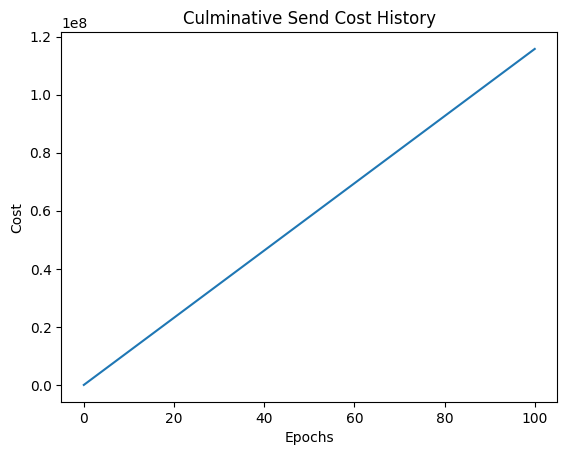

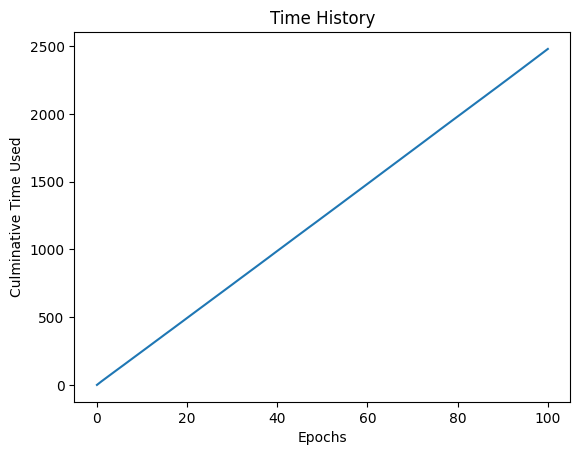

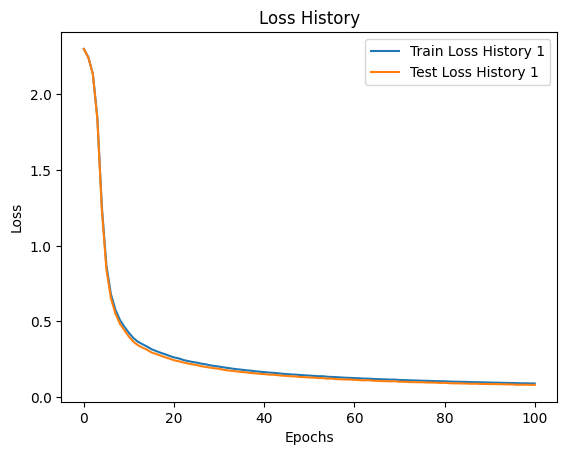

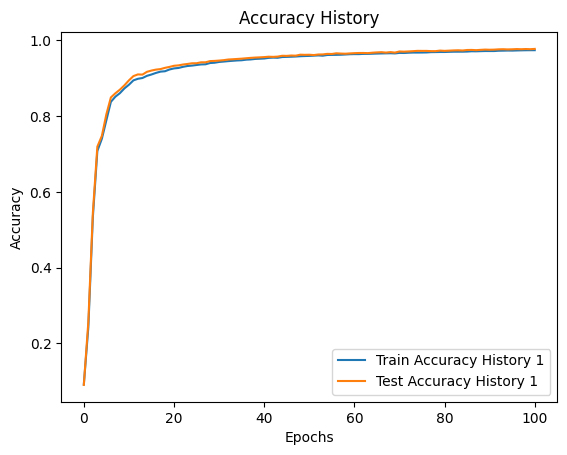

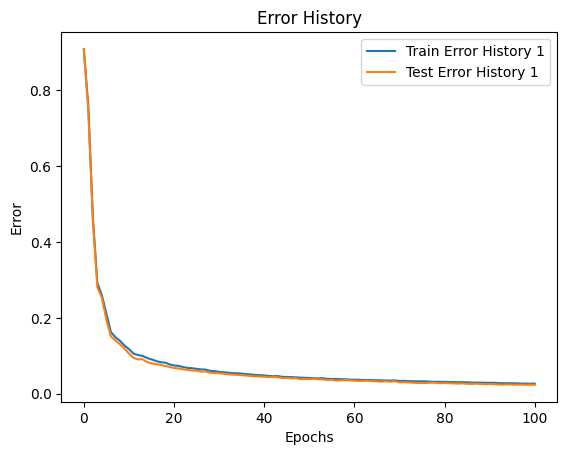

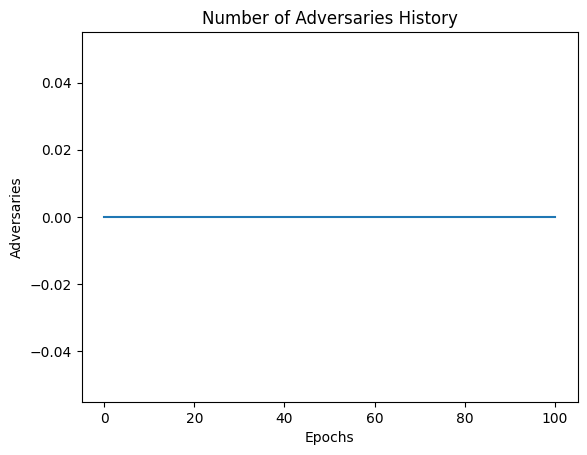

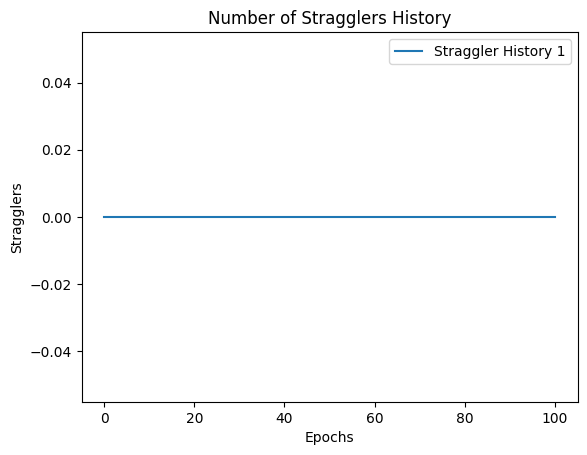

ValueError: not enough values to unpack (expected 10, got 9)

In [6]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [100]
random_sample_client_number_list = [20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
straggler_list = [0, 50, 90, 0, 50, 90, 0, 50, 90]
mu_list = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 9

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, straggler_list, mu_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = False
custom_split_dataset_power_law = True
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [100]
random_sample_client_number_list = [20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
straggler_list = [0, 50, 90, 0, 50, 90, 0, 50, 90]
mu_list = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
adversary_list = [0]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [10000]

experiment_rounds = 9

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, straggler_list, mu_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

**FedProx Adversaries**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_FedProx
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10]
random_sample_client_number_list = [10]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
straggler_list = [0]
mu_list = [1.0, 1.0, 1.0, 1.0]
adversary_list = [1]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [0, 1, 10, 10000]

experiment_rounds = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedProx"
experiment_FedProx_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, straggler_list, mu_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

**FedAvg Adversary**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 10, 10, 10, 100, 100, 100, 100]
random_sample_client_number_list = [10, 10, 10, 10, 20, 20, 20, 20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_averaging
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [1, 1, 1, 1, 20, 20, 20, 20]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [0, 1, 10, 1000, 0, 1, 10, 1000]

experiment_rounds = 8

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

**FedMedian**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 10, 10, 10, 100, 100, 100, 100]
random_sample_client_number_list = [10, 10, 10, 10, 20, 20, 20, 20]
learning_rate_list = 0.03
batch_size_list = 128
aggregate_func_list = federated_median
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
adversary_list = [1, 1, 1, 1, 20, 20, 20, 20]
adversary_attack_func_list = [adversarial_attack_by_value]
adversary_attack_value_list = [0, 1, 10, 1000, 0, 1, 10, 1000]

experiment_rounds = 8

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "FedAvg"
experiment_FedAvg_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, experiment_rounds)

**SCAFFOLD Weight Adversary**

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 10, 10, 10, 100, 100, 100, 100]
random_sample_client_number_list = [10, 10, 10, 10, 20, 20, 20, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_averaging_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = [False]
straggler_list = [0]
adversary_list = [1, 1, 1, 1, 20, 20, 20, 20]
adversary_attack_func_list = [adversarial_attack_by_control_variable_Scaffold]
adversary_attack_value_list = [0, 1, 10, 10000, 0, 1, 10, 10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 8

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

**SCAFFOLD Control Variable Adversary**

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 10, 10, 10, 100, 100, 100, 100]
random_sample_client_number_list = [10, 10, 10, 10, 20, 20, 20, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_averaging_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = [False]
straggler_list = [0]
adversary_list = [1, 1, 1, 1, 20, 20, 20, 20]
adversary_attack_func_list = [adversarial_attack_by_control_variable_Scaffold]
adversary_attack_value_list = [0, 1, 10, 10000, 0, 1, 10, 10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 8

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

**ScaffoldMedian Weight**

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 10, 10, 10, 100, 100, 100, 100]
random_sample_client_number_list = [10, 10, 10, 10, 20, 20, 20, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_median_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = [False]
straggler_list = [0]
adversary_list = [1, 1, 1, 1, 20, 20, 20, 20]
adversary_attack_func_list = [adversarial_attack_by_value_Scaffold]
adversary_attack_value_list = [0, 1, 10, 10000, 0, 1, 10, 10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 8

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

**ScaffoldMedian Control Variable**

In [ ]:
modelType = model_type_preset
optimizerType = ScaffoldOptimizer
itera_func = iterate_model_simple
dataset_distributing_func = split_datasets_for_clients_custom

custom_split_dataset_iid = True
custom_split_dataset_power_law = False
custom_split_dataset_balance = False
custom_split_dataset_seed = 42

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [10, 10, 10, 10, 100, 100, 100, 100]
random_sample_client_number_list = [10, 10, 10, 10, 20, 20, 20, 20]
learning_rate_list = 0.03
global_step_size_list = 1.0
batch_size_list = [128]
aggregate_func_list = federated_median_Scaffold
loss_func_list = loss_func_preset
accuracy_func_list = get_accuracy
error_func_list = get_error
Scaffold_update_controls_use_gradient_list = [False]
straggler_list = [0]
adversary_list = [1, 1, 1, 1, 20, 20, 20, 20]
adversary_attack_func_list = [adversarial_attack_by_control_variable_Scaffold]
adversary_attack_value_list = [0, 1, 10, 10000, 0, 1, 10, 10000]
adversary_attack_Scaffold_all_list = [False]

experiment_rounds = 8

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

current_method_name = "Scaffold"
experiment_Scaffold_model(train_dataset, test_dataset, dataset_distributing_func, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, random_sample_client_number_list, learning_rate_list, global_step_size_list, batch_size_list, aggregate_func_list, loss_func_list, accuracy_func_list, error_func_list, Scaffold_update_controls_use_gradient_list, straggler_list, adversary_list, adversary_attack_func_list, adversary_attack_value_list, adversary_attack_Scaffold_all_list, experiment_rounds)

## Section 3 Analysis ##

#### Section 3.0 Loading Data ####

**Clear and Initialize Data**

In [ ]:
data_cost_history_total = []
data_time_history_total = []
data_adversary_history_total = []
data_straggler_history_total = []
data_train_loss_history_total = []
data_train_accuracy_history_total = []
data_train_error_history_total = []
data_test_loss_history_total = []
data_test_accuracy_history_total = []
data_test_error_history_total = []

**Loading Data Manually**

In [ ]:
# Change the filename_load path manually here!!
filename_load_list = ["MNIST_Scaffold_GE_50_LE_3_C_50_RC_25_lr_0.03_B_128_2024-04-07 16.25.58_1.npy",
                      "MNIST_Scaffold_GE_50_LE_3_C_50_RC_25_lr_0.03_B_128_2024-04-07 16.25.58_2.npy"]
data_append_load = True
load_consider_cost_bool = True
load_consider_time_bool = True
load_consider_adversary_bool = True
load_consider_straggler_bool = True

for filename_load in filename_load_list:
    print("============================================")
    print("*** Loading file...                     ***")
    print("============================================")
    try:
        # Load the file
        load_result = np.load(filename_load)
        print('Result has been loaded from the file: ', filename_load)

        # Load the attributes from the file
        if load_consider_cost_bool is True:
            data_cost_history = load_result['cost_history']
        if load_consider_time_bool is True:
            data_time_history = load_result['time_history']
        if load_consider_adversary_bool is True:
            data_adversary_history = load_result['adversary_history']
        if load_consider_adversary_bool is True:
            data_straggler_history = load_result['straggler_history']
        data_train_loss_history = load_result['train_loss_history']
        data_train_accuracy_history = load_result['train_accuracy_history']
        data_train_error_history = load_result['train_error_history']
        data_test_loss_history = load_result['test_loss_history']
        data_test_accuracy_history = load_result['test_accuracy_history']
        data_test_error_history = load_result['test_error_history']

        print("=======Content of the File=======")
        print(load_result.files)

        print("=======VISUALIZATION RESULT=======")
        if load_consider_cost_bool is True:
            plot_cost_history([data_cost_history], save=False)
        if load_consider_time_bool is True:
            plot_time_history([data_time_history], save=False)
        if load_consider_adversary_bool is True:
            plot_adversary_history([data_adversary_history], save=False)
        if load_consider_straggler_bool is True:
            plot_straggler_history([data_straggler_history], save=False)
        plot_loss_history([data_train_loss_history], [data_test_loss_history], save=False)
        plot_accuracy_history([data_train_accuracy_history], [data_test_accuracy_history], save=False)
        plot_error_history([data_train_error_history], [data_test_error_history], save=False)

        print("=======STATUS RESULT=======")
        if load_consider_cost_bool is True:
            print("Cost History: ", data_cost_history)
        if load_consider_time_bool is True:
            print("Time History: ", data_time_history)
        if load_consider_adversary_bool is True:
            print("Adversary History: ", data_adversary_history)
        if load_consider_straggler_bool is True:
            print("Straggler History: ", data_straggler_history)

        print("=======TRAIN RESULT=======")
        print("Train Loss History: ", data_train_loss_history)
        print("Train Accuracy History: ", data_train_accuracy_history)
        print("Train Error History: ", data_train_error_history)

        print("=======TEST RESULT=======")
        print("Test Loss History: ", data_test_loss_history)
        print("Test Accuracy History: ", data_test_accuracy_history)
        print("Test Error History: ", data_test_error_history)

        # Append the data
        if data_append_load:
            if load_consider_cost_bool is True:
                data_cost_history_total.append(data_cost_history)
            if load_consider_time_bool is True:
                data_time_history_total.append(data_time_history)
            if load_consider_adversary_bool is True:
                data_adversary_history_total.append(data_adversary_history)
            if load_consider_straggler_bool is True:
                data_straggler_history_total.append(data_straggler_history)
            data_train_loss_history_total.append(data_train_loss_history)
            data_train_accuracy_history_total.append(data_train_accuracy_history)
            data_train_error_history_total.append(data_train_error_history)
            data_test_loss_history_total.append(data_test_loss_history)
            data_test_accuracy_history_total.append(data_test_accuracy_history)
            data_test_error_history_total.append(data_test_error_history)
    except (FileNotFoundError, IOError):
        print("Failed to load the file: ", filename_load)
    print("")

#### Section 3.1 Data Visualization ####

**Visualize All Data Directly**

In [ ]:
plot_cost_history(data_cost_history_total, save=False)
plot_time_history(data_time_history_total, save=False)
plot_adversary_history(data_adversary_history_total, save=False)
plot_straggler_history(data_straggler_history_total, save=False)
plot_loss_history(data_train_loss_history_total, data_test_loss_history_total, save=False)
plot_accuracy_history(data_train_accuracy_history_total, data_test_accuracy_history_total, save=False)
plot_error_history(data_train_error_history_total, data_test_error_history_total, save=False)

**Experiment Graph in Centralized Training**

In [ ]:
plot_parameter_list = [1, 2, 3, 4, 5, 10]
plot_save_fig_bool = False
plot_show_train_bool = True
plot_show_test_bool = True
plot_log_scale = False

plot_different_parameter_train_loss_history = convert_to_list(data_train_loss_history_total)
plot_different_parameter_test_loss_history = convert_to_list(data_test_loss_history_total)
if plot_show_train_bool is True:
    for i, plot_train_loss_history in enumerate(plot_different_parameter_train_loss_history):
        plt.plot(plot_train_loss_history, label=f"Train Loss History")
if plot_show_test_bool is True:
    for i, plot_test_loss_history in enumerate(plot_different_parameter_test_loss_history):
        plt.plot(plot_test_loss_history, label=f"Test Loss History")
plt.xlabel("Epochs")
if plot_log_scale is True:
    plt.ylabel("Log Loss")
    plt.yscale('log')
else:
    plt.ylabel("Loss")
plt.title("Loss History")
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_loss_history_centralized_{train_start_time}.png')
plt.show()

plot_different_parameter_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_parameter_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
if plot_show_train_bool is True:
    for i, plot_train_accuracy_history in enumerate(plot_different_parameter_train_accuracy_history):
        plt.plot(plot_train_accuracy_history, label=f"Train Accuracy History")
if plot_show_test_bool is True:
    for i, plot_test_accuracy_history in enumerate(plot_different_parameter_test_accuracy_history):
        plt.plot(plot_test_accuracy_history, label=f"Test Accuracy History")
plt.xlabel("Epochs")
if plot_log_scale is True:
    plt.ylabel("Log Accuracy")
    plt.yscale('log')
else:
    plt.ylabel("Accuracy")
plt.title("Accuracy History")
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_accuracy_history_centralized_{train_start_time}.png')
plt.show()

plot_different_parameter_train_error_history = convert_to_list(data_train_error_history_total)
plot_different_parameter_test_error_history = convert_to_list(data_test_error_history_total)
if plot_show_train_bool is True:
    for i, plot_train_error_history in enumerate(plot_different_parameter_train_error_history):
        plt.plot(plot_train_error_history, label=f"Train Error History")
if plot_show_test_bool is True:
    for i, plot_test_error_history in enumerate(plot_different_parameter_test_error_history):
        plt.plot(plot_test_error_history, label=f"Test Error History")
plt.xlabel("Epochs")
if plot_log_scale is True:
    plt.ylabel("Log Error")
    plt.yscale('log')
else:
    plt.ylabel("Error")
plt.title("Error History")
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_error_history_centralized_{train_start_time}.png')
plt.show()

**Experiment Graph between different parameters in Federated Learning**

In [ ]:
plot_parameters_list = [0, 1]
plot_title_strings = "different stragglers"
plot_legend_strings = "stragglers"
plot_save_fig_bool = False
plot_show_train_bool = True
plot_show_test_bool = False
plot_log_scale = False

plot_different_parameter_train_loss_history = convert_to_list(data_train_loss_history_total)
plot_different_parameter_test_loss_history = convert_to_list(data_test_loss_history_total)
if plot_show_train_bool is True:
    for i, plot_train_loss_history in enumerate(plot_different_parameter_train_loss_history):
        plt.plot(plot_train_loss_history, label=f"Train Loss History with {plot_legend_strings} = {plot_parameters_list[i]}")
if plot_show_test_bool is True:
    for i, plot_test_loss_history in enumerate(plot_different_parameter_test_loss_history):
        plt.plot(plot_test_loss_history, label=f"Test Loss History with {plot_legend_strings} = {plot_parameters_list[i]}")
plt.xlabel("Communication Rounds")
if plot_log_scale is True:
    plt.ylabel("Log Loss")
    plt.yscale('log')
else:
    plt.ylabel("Loss")
plt.title("Loss History with " + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_loss_history_{plot_title_strings}_{train_start_time}.png')
plt.show()

plot_different_parameter_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_parameter_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
if plot_show_train_bool is True:
    for i, plot_train_accuracy_history in enumerate(plot_different_parameter_train_accuracy_history):
        plt.plot(plot_train_accuracy_history, label=f"Train Accuracy History with {plot_legend_strings} = {plot_parameters_list[i]}")
if plot_show_test_bool is True:
    for i, plot_test_accuracy_history in enumerate(plot_different_parameter_test_accuracy_history):
        plt.plot(plot_test_accuracy_history, label=f"Test Aacuracy History with {plot_legend_strings} = {plot_parameters_list[i]}")
plt.xlabel("Communication Rounds")
if plot_log_scale is True:
    plt.ylabel("Log Accuracy")
    plt.yscale('log')
else:
    plt.ylabel("Accuracy")
plt.title("Accuracy History with " + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_accuracy_history_{plot_title_strings}_{train_start_time}.png')
plt.show()

plot_different_parameter_train_error_history = convert_to_list(data_train_error_history_total)
plot_different_parameter_test_error_history = convert_to_list(data_test_error_history_total)
if plot_show_train_bool is True:
    for i, plot_train_error_history in enumerate(plot_different_parameter_train_error_history):
        plt.plot(plot_train_error_history, label=f"Train Error History with {plot_legend_strings} = {plot_parameters_list[i]}")
if plot_show_test_bool is True:
    for i, plot_test_error_history in enumerate(plot_different_parameter_test_error_history):
        plt.plot(plot_test_error_history, label=f"Test Error History with {plot_legend_strings} = {plot_parameters_list[i]}")
plt.xlabel("Communication Rounds")
if plot_log_scale is True:
    plt.ylabel("Log Error")
    plt.yscale('log')
else:
    plt.ylabel("Error")
plt.title("Error History with " + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_error_history_{plot_title_strings}_{train_start_time}.png')
plt.show()

plot_different_parameter_time_history = convert_to_list(data_time_history_total)
for i, plot_time_history in enumerate(plot_different_parameter_time_history):
    plt.plot(plot_time_history, label=f"Time History with {plot_legend_strings} = {plot_parameters_list[i]}")
plt.xlabel("Communication Rounds")
if plot_log_scale is True:
    plt.ylabel("Log Culminative Time Used")
    plt.yscale('log')
else:
    plt.ylabel("Culminative Time Used")
plt.title("Time History with " + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_time_history_{plot_title_strings}_{train_start_time}.png')
plt.show()

plot_different_parameter_cost_history = convert_to_list(data_cost_history_total)
for i, plot_cost_history in enumerate(plot_different_parameter_cost_history):
    plt.plot(plot_cost_history, label=f"Time History with {plot_legend_strings} = {plot_parameters_list[i]}")
plt.xlabel("Communication Rounds")
if plot_log_scale is True:
    plt.ylabel("Log Cost")
    plt.yscale('log')
else:
    plt.ylabel("Cost")
plt.title("Culminative Send Cost History with " + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_cost_history_{plot_title_strings}_{train_start_time}.png')
plt.show()

plot_different_parameter_adversary_history = convert_to_list(data_adversary_history_total)
for i, plot_adversary_history in enumerate(plot_different_parameter_adversary_history):
    plt.plot(plot_adversary_history, label=f"Adversary History with {plot_legend_strings} = {plot_parameters_list[i]}")
plt.xlabel("Communication Rounds")
if plot_log_scale is True:
    plt.ylabel("Log Adversaries")
    plt.yscale('log')
else:
    plt.ylabel("Adversaries")
plt.title("Number of Adversary History with " + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_adversary_history_{plot_title_strings}_{train_start_time}.png')
plt.show()

plot_different_parameter_straggler_history = convert_to_list(data_adversary_history_total)
for i, plot_straggler_history in enumerate(plot_different_parameter_straggler_history):
    plt.plot(plot_straggler_history, label=f"Straggler History with {plot_legend_strings} = {plot_parameters_list[i]}")
plt.xlabel("Communication Rounds")
if plot_log_scale is True:
    plt.ylabel("Log Stragglers")
    plt.yscale('log')
else:
    plt.ylabel("Stragglers")
plt.title("Number of Stragglers History with " + plot_title_strings)
plt.legend()
if plot_save_fig_bool is True:
    plt.savefig(f'Analysis_{current_dataset_name}_straggler_history_{plot_title_strings}_{train_start_time}.png')
plt.show()

#### Section 3.2 Analysing ####

**Variance Analysis**

In [ ]:
analysis_id = 0
for data_cost_history, data_time_history, data_train_loss_history, data_train_accuracy_history, data_train_error_history, data_test_loss_history, data_test_accuracy_history, data_test_error_history in zip(data_cost_history_total, data_time_history_total, data_train_loss_history_total, data_train_accuracy_history_total, data_train_error_history_total, data_test_loss_history_total, data_test_accuracy_history_total, data_test_error_history_total):
    analysis_id += 1
    print(f'<!======Analaysis ID = {analysis_id}=======!>')
    cost_variance = statistics.variance(data_cost_history)
    time_variance = statistics.variance(data_time_history)
    train_loss_variance = statistics.variance(data_train_loss_history)
    train_accuracy_variance = statistics.variance(data_train_accuracy_history)
    train_error_variance = statistics.variance(data_train_error_history)
    test_loss_variance = statistics.variance(data_test_loss_history)
    test_accuracy_variance = statistics.variance(data_test_accuracy_history)
    test_error_variance = statistics.variance(data_test_error_history)
    print("=======VARIANCE RESULT=======")
    print("Cost Variance: ", cost_variance)
    print("Time Variance: ", time_variance)
    print("Train Loss Variance: ", train_loss_variance)
    print("Train Accuracy Variance: ", train_accuracy_variance)
    print("Train Error Variance: ", train_error_variance)
    print("Test Loss Variance: ", test_loss_variance)
    print("Test Accuracy Variance: ", test_accuracy_variance)
    print("Test Error Variance: ", test_error_variance)

In [ ]:
analysis_variance_subset_min = 0
analysis_variance_subset_max = len(data_cost_history) // 2

analysis_id = 0
for data_cost_history, data_time_history, data_train_loss_history, data_train_accuracy_history, data_train_error_history, data_test_loss_history, data_test_accuracy_history, data_test_error_history in zip(data_cost_history_total, data_time_history_total, data_train_loss_history_total, data_train_accuracy_history_total, data_train_error_history_total, data_test_loss_history_total, data_test_accuracy_history_total, data_test_error_history_total):
    analysis_id += 1
    print(f'<!======Analaysis ID = {analysis_id}=======!>')
    cost_variance_subset = statistics.variance(data_cost_history[analysis_variance_subset_min:analysis_variance_subset_max])
    time_variance_subset = statistics.variance(data_time_history[analysis_variance_subset_min:analysis_variance_subset_max])
    train_loss_variance_subset = statistics.variance(data_train_loss_history[analysis_variance_subset_min:analysis_variance_subset_max])
    train_accuracy_variance_subset = statistics.variance(data_train_accuracy_history[analysis_variance_subset_min:analysis_variance_subset_max])
    train_error_variance_subset = statistics.variance(data_train_error_history[analysis_variance_subset_min:analysis_variance_subset_max])
    test_loss_variance_subset = statistics.variance(data_test_loss_history[analysis_variance_subset_min:analysis_variance_subset_max])
    test_accuracy_variance_subset = statistics.variance(data_test_accuracy_history[analysis_variance_subset_min:analysis_variance_subset_max])
    test_error_variance_subset = statistics.variance(data_test_error_history[analysis_variance_subset_min:analysis_variance_subset_max])
    print(f'=======VARIANCE RESULT IN SUBSET BETWEEN {analysis_variance_subset_min} and {analysis_variance_subset_max}=======')
    print("Cost Variance in Subset: ", cost_variance_subset)
    print("Time Variance in Subset: ", time_variance_subset)
    print("Train Loss Variance in Subset: ", train_loss_variance_subset)
    print("Train Accuracy Variance in Subset: ", train_accuracy_variance_subset)
    print("Train Error Variance in Subset: ", train_error_variance_subset)
    print("Test Loss Variance in Subset: ", test_loss_variance_subset)
    print("Test Accuracy Variance in Subset: ", test_accuracy_variance_subset)
    print("Test Error Variance in Subset: ", test_error_variance_subset)

In [ ]:
analysis_id = 0
for data_cost_history, data_time_history, data_train_loss_history, data_train_accuracy_history, data_train_error_history, data_test_loss_history, data_test_accuracy_history, data_test_error_history in zip(data_cost_history_total, data_time_history_total, data_train_loss_history_total, data_train_accuracy_history_total, data_train_error_history_total, data_test_loss_history_total, data_test_accuracy_history_total, data_test_error_history_total):
    analysis_id += 1
    print(f'<!======Analaysis ID = {analysis_id}=======!>')
    cost_variance_subset = statistics.variance(data_cost_history[:len(data_cost_history) // 2])
    time_variance_subset = statistics.variance(data_time_history[:len(data_time_history) // 2])
    train_loss_variance_subset = statistics.variance(data_train_loss_history[:len(data_train_loss_history) // 2])
    train_accuracy_variance_subset = statistics.variance(data_train_accuracy_history[:len(data_train_accuracy_history) // 2])
    train_error_variance_subset = statistics.variance(data_train_error_history[:len(data_train_error_history) // 2])
    test_loss_variance_subset = statistics.variance(data_test_loss_history[:len(data_test_loss_history) // 2])
    test_accuracy_variance_subset = statistics.variance(data_test_accuracy_history[:len(data_test_accuracy_history) // 2])
    test_error_variance_subset = statistics.variance(data_test_error_history[:len(data_test_error_history) // 2])
    print("=======VARIANCE FIRST SUBSET RESULT=======")
    print("Cost Variance in Subset: ", cost_variance_subset)
    print("Time Variance in Subset: ", time_variance_subset)
    print("Train Loss Variance in Subset: ", train_loss_variance_subset)
    print("Train Accuracy Variance in Subset: ", train_accuracy_variance_subset)
    print("Train Error Variance in Subset: ", train_error_variance_subset)
    print("Test Loss Variance in Subset: ", test_loss_variance_subset)
    print("Test Accuracy Variance in Subset: ", test_accuracy_variance_subset)
    print("Test Error Variance in Subset: ", test_error_variance_subset)

In [ ]:
analysis_id = 0
for data_cost_history, data_time_history, data_train_loss_history, data_train_accuracy_history, data_train_error_history, data_test_loss_history, data_test_accuracy_history, data_test_error_history in zip(data_cost_history_total, data_time_history_total, data_train_loss_history_total, data_train_accuracy_history_total, data_train_error_history_total, data_test_loss_history_total, data_test_accuracy_history_total, data_test_error_history_total):
    analysis_id += 1
    print(f'<!======Analaysis ID = {analysis_id}=======!>')
    cost_variance_subset = statistics.variance(data_cost_history[len(data_cost_history) // 2:])
    time_variance_subset = statistics.variance(data_time_history[len(data_time_history) // 2:])
    train_loss_variance_subset = statistics.variance(data_train_loss_history[len(data_train_loss_history) // 2:])
    train_accuracy_variance_subset = statistics.variance(data_train_accuracy_history[len(data_train_accuracy_history) // 2:])
    train_error_variance_subset = statistics.variance(data_train_error_history[len(data_train_error_history) // 2:])
    test_loss_variance_subset = statistics.variance(data_test_loss_history[len(data_test_loss_history) // 2:])
    test_accuracy_variance_subset = statistics.variance(data_test_accuracy_history[len(data_test_accuracy_history) // 2:])
    test_error_variance_subset = statistics.variance(data_test_error_history[len(data_test_error_history) // 2:])
    print("=======VARIANCE LAST SUBSET RESULT=======")
    print("Cost Variance in Subset: ", cost_variance_subset)
    print("Time Variance in Subset: ", time_variance_subset)
    print("Train Loss Variance in Subset: ", train_loss_variance_subset)
    print("Train Accuracy Variance in Subset: ", train_accuracy_variance_subset)
    print("Train Error Variance in Subset: ", train_error_variance_subset)
    print("Test Loss Variance in Subset: ", test_loss_variance_subset)
    print("Test Accuracy Variance in Subset: ", test_accuracy_variance_subset)
    print("Test Error Variance in Subset: ", test_error_variance_subset)

**Average Analysis**

In [ ]:
analysis_average_subset_min = 0
analysis_average_subset_max = len(data_cost_history) // 2

analysis_id = 0
for data_cost_history, data_time_history, data_train_loss_history, data_train_accuracy_history, data_train_error_history, data_test_loss_history, data_test_accuracy_history, data_test_error_history in zip(data_cost_history_total, data_time_history_total, data_train_loss_history_total, data_train_accuracy_history_total, data_train_error_history_total, data_test_loss_history_total, data_test_accuracy_history_total, data_test_error_history_total):
    analysis_id += 1
    print(f'<!======Analaysis ID = {analysis_id}=======!>')
    cost_average_subset = statistics.mean(data_cost_history[analysis_average_subset_min:analysis_average_subset_max])
    time_average_subset = statistics.mean(data_time_history[analysis_average_subset_min:analysis_average_subset_max])
    train_loss_average_subset = statistics.mean(data_train_loss_history[analysis_average_subset_min:analysis_average_subset_max])
    train_accuracy_average_subset = statistics.mean(data_train_accuracy_history[analysis_average_subset_min:analysis_average_subset_max])
    train_error_average_subset = statistics.mean(data_train_error_history[analysis_average_subset_min:analysis_average_subset_max])
    test_loss_average_subset = statistics.mean(data_test_loss_history[analysis_average_subset_min:analysis_average_subset_max])
    test_accuracy_average_subset = statistics.mean(data_test_accuracy_history[analysis_average_subset_min:analysis_average_subset_max])
    test_error_average_subset = statistics.mean(data_test_error_history[analysis_average_subset_min:analysis_average_subset_max])
    print(f'=======AVERAGE RESULT IN SUBSET BETWEEN {analysis_average_subset_min} and {analysis_average_subset_max}=======')
    print("Cost Average in Subset: ", cost_average_subset)
    print("Time Average in Subset: ", time_average_subset)
    print("Train Loss Average in Subset: ", train_loss_average_subset)
    print("Train Accuracy Average in Subset: ", train_accuracy_average_subset)
    print("Train Error Average in Subset: ", train_error_average_subset)
    print("Test Loss Average in Subset: ", test_loss_average_subset)
    print("Test Accuracy Average in Subset: ", test_accuracy_average_subset)
    print("Test Error Average in Subset: ", test_error_average_subset)

**Test Image Classification**

In [ ]:
test_image_path = "Test.png"
test_model_type = MNIST_CNN_Model
test_model_path = "MNIST_FedAvg_with_global_epochs_100_local_epochs_3_num_clients_1_batch_size_128_2024-03-01 16.14.36_model_state_dict.pth"
test_image_resize = 28
test_image_togrey = True

test_global_model = test_model_type()
test_global_model.load_state_dict(torch.load(test_model_path, map_location=device))

if test_image_togrey is True:
    test_image = 1.0 - cv2.cvtColor(cv2.resize(load_image(test_image_path), (test_image_resize, test_image_resize)), cv2.COLOR_RGB2GRAY)
else:
    test_image = cv2.resize(load_image(test_image_path), (test_image_resize, test_image_resize))
plt.imshow(test_image, cmap='gray')

test_image_torch = torch.Tensor(test_image[np.newaxis, np.newaxis])
test_predicted_label_array = test_global_model(test_image_torch).detach().numpy()[0, ...]
print('The chances for predicted labels are: ', test_predicted_label_array)

test_predicted_label = np.argmax(test_predicted_label_array)

print('The predicted label is: ', test_predicted_label)